In [1]:
%matplotlib inline
import os 
import theano
from theano import tensor as T
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

In [2]:
""" What does the softmax learn? """
def analyze_net(w_o, img_dim):    
    matplotlib.rc('xtick', labelsize=30) 
    matplotlib.rc('ytick', labelsize=30)   

    a = np.array(w_o.get_value())  
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(40, 15))
    for i, ax in enumerate(axes.flat):
        ax.set_title(str(i), fontsize=50)
        im = ax.imshow(a[:,i].reshape(img_dim, img_dim), interpolation='none')

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    plt.show()
    #plt.pause(0.1)
    
def one_hot(x, n):
    if type(x) == list:
        x = np.array(x)       
    x = x.flatten()
    o_h = np.zeros((len(x), n))
    o_h[np.arange(len(x)), x] = 1
    return o_h

def mnist(ntrain=60000, ntest=10000, onehot=True):
    """
    Load and devide MNIST data set into train, test sets
    X is image, and Y is its label.
    The image size is 28*28, and we flatten it to a 784-dim vector
    
    The label is represented in onehot vector. A onehot vector is 
    a vector which is 0 in most dimensions, and 1 in a single 
    dimension. In this case, the nth digit will be represented as 
    a vector which is 1 in the nth dimensions. 
    For example, 0 would be [1,0,0,0,0,0,0,0,0,0,0]. 
    """
    
    data_dir = 'datasets\\mnist'
    
    fd = open(os.path.join(data_dir, 'train-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    trX = loaded[16:].reshape((60000, 28*28)).astype(float)

    fd = open(os.path.join(data_dir, 'train-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    trY = loaded[8:].reshape((60000))

    fd = open(os.path.join(data_dir, 't10k-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    teX = loaded[16:].reshape((10000, 28*28)).astype(float)

    fd = open(os.path.join(data_dir, 't10k-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    teY = loaded[8:].reshape((10000))

    trX = trX/255.
    teX = teX/255.

    trX = trX[:ntrain]
    trY = trY[:ntrain]

    teX = teX[:ntest]
    teY = teY[:ntest]
    
    if onehot:
        trY = one_hot(trY, 10)
        teY = one_hot(teY, 10)
    else:
        trY = np.asarray(trY)
        teY = np.asarray(teY)

    return trX,teX,trY,teY

trX, teX, trY, teY = mnist(onehot=True)  #Loading data matrices

In [3]:
def floatX(X):
    """ Conver to correct dtype """
    return np.asarray(X, dtype=theano.config.floatX)

def init_weights(shape):
    """ initalize model parameters """
    return theano.shared(floatX(np.random.randn(*shape) * 0.01))

def model(X, w):
    """Logistic regresion in matrix format y = softmax(X.w)
    This neural net has no hidden layer.
    """
    return T.nnet.softmax(T.dot(X, w))


In [4]:
X = T.fmatrix()  # matrix types variables
Y = T.fmatrix()

w = init_weights((784, 10))  # initalize weights matrix

In [5]:
py_x = model(X, w)  # p(y|x): probability of label given the input
y_pred = T.argmax(py_x, axis=1)  # probality outputs and max predictions

In [6]:
"""
In order to train our model, we need to define what it means for the model 
to be good. Well, actually, in machine learning we typically define what it 
means for a model to be bad, called the cost or loss, and then try to minimize 
how bad it is. But the two are equivalent.

One very common, very nice cost function is "cross-entropy." Surprisingly, 
cross-entropy arises from thinking about information compressing codes in 
information theory but it winds up being an important idea in lots of areas, 
from gambling to machine learning. It's defined:

              H_Y(py_x) = - \sum_i y_i * log(py_x_i)
              
where Y os the true distribution (the one-hot vector we'll input)
py_x is our predicted probability distribution
In some rough sense, the cross-entropy is measuring how inefficient our 
predictions are for describing the truth.   

"""
cost = T.mean(T.nnet.categorical_crossentropy(py_x, Y))

In [7]:
gradient = T.grad(cost=cost, wrt=w)  # Compute gradient
update = [[w, w - gradient * 0.05]]  # Weight update with gradient descent

# compile train function
train = theano.function(inputs=[X, Y], outputs=cost, updates=update, allow_input_downcast=True)

# compile prediction function
predict = theano.function(inputs=[X], outputs=y_pred, allow_input_downcast=True)

In [8]:
# run training with 100 iteration and on mini-batches of 128 examples
for i in range(10):
    for start, end in zip(range(0, len(trX), 128), range(128, len(trX), 128)):
        cost = train(trX[start:end], trY[start:end])
    print i, np.mean(np.argmax(teY, axis=1) == predict(teX))
        

0 0.8846
1 0.8976
2 0.9042
3 0.9079
4 0.9095
5 0.9108
6 0.9123
7 0.9136
8 0.9147
9 0.9155


Softmax [@A] ''   
 |dot [@B] ''   
   |<TensorType(float32, matrix)> [@C]
   |<TensorType(float64, matrix)> [@D]


C:\Users\ngbach\AppData\Local\Continuum\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


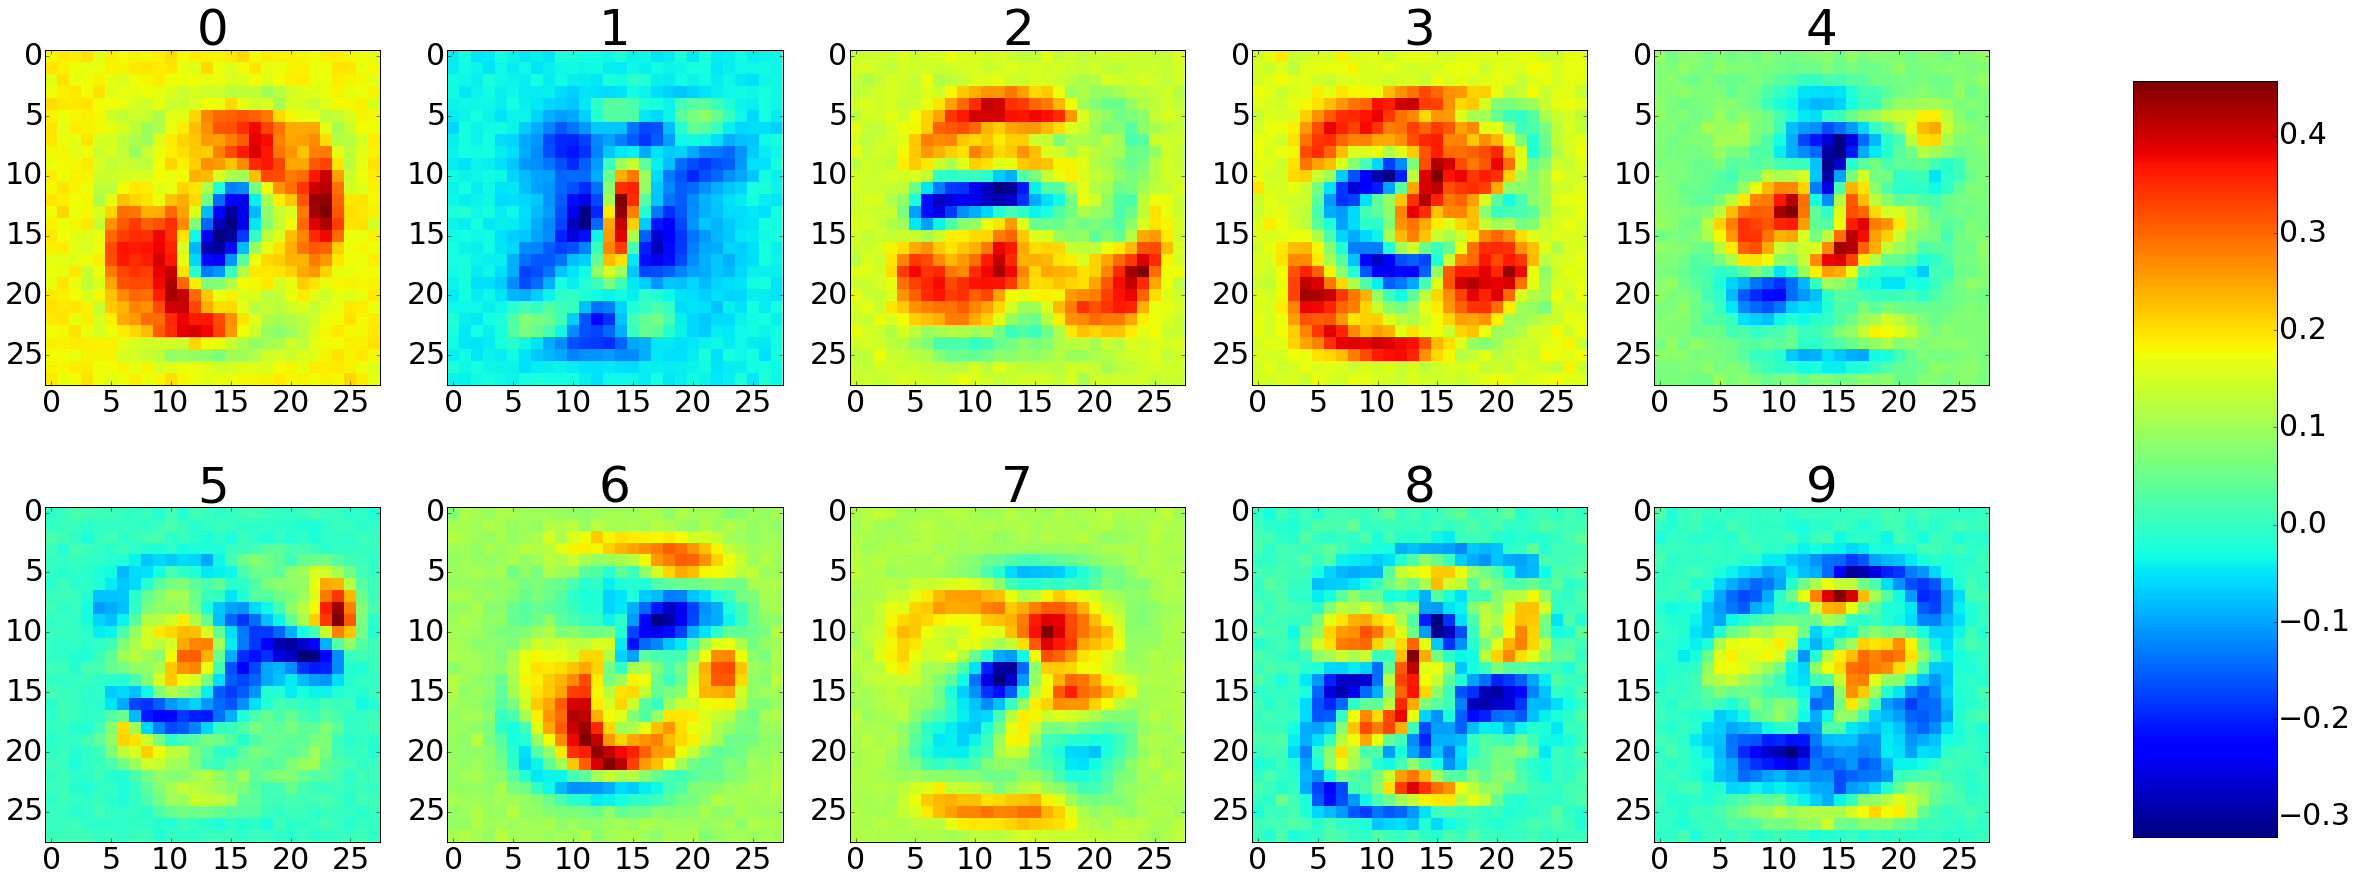

In [9]:
""" What does the softmax learn? """
theano.printing.debugprint(py_x)
analyze_net(w, 28)

In [6]:
""" A feed forward neural network with 1 hidden layer
The NN architecture is 784 -> 635 -> 10
We change model() and use Schotastic Gradient Descent to update weight()
"""

def sgd(cost, params, lr=0.05):
    """generalize to compute gradien descent on all model parameters"""
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        updates.append([p, p - g * lr])
    return updates

def model(X, w_h, w_o):
    # hidden layer use sigmod as its activation function
    h = T.nnet.sigmoid(T.dot(X, w_h))
        
    #output layer still uses softmax
    pyx = T.nnet.softmax(T.dot(h, w_o))
    return pyx


0 0.7089
1 0.8289
2 0.8684
3 0.8838
4 0.8907
5 0.8952
6 0.8986
7 0.9017
8 0.9045
9 0.9074


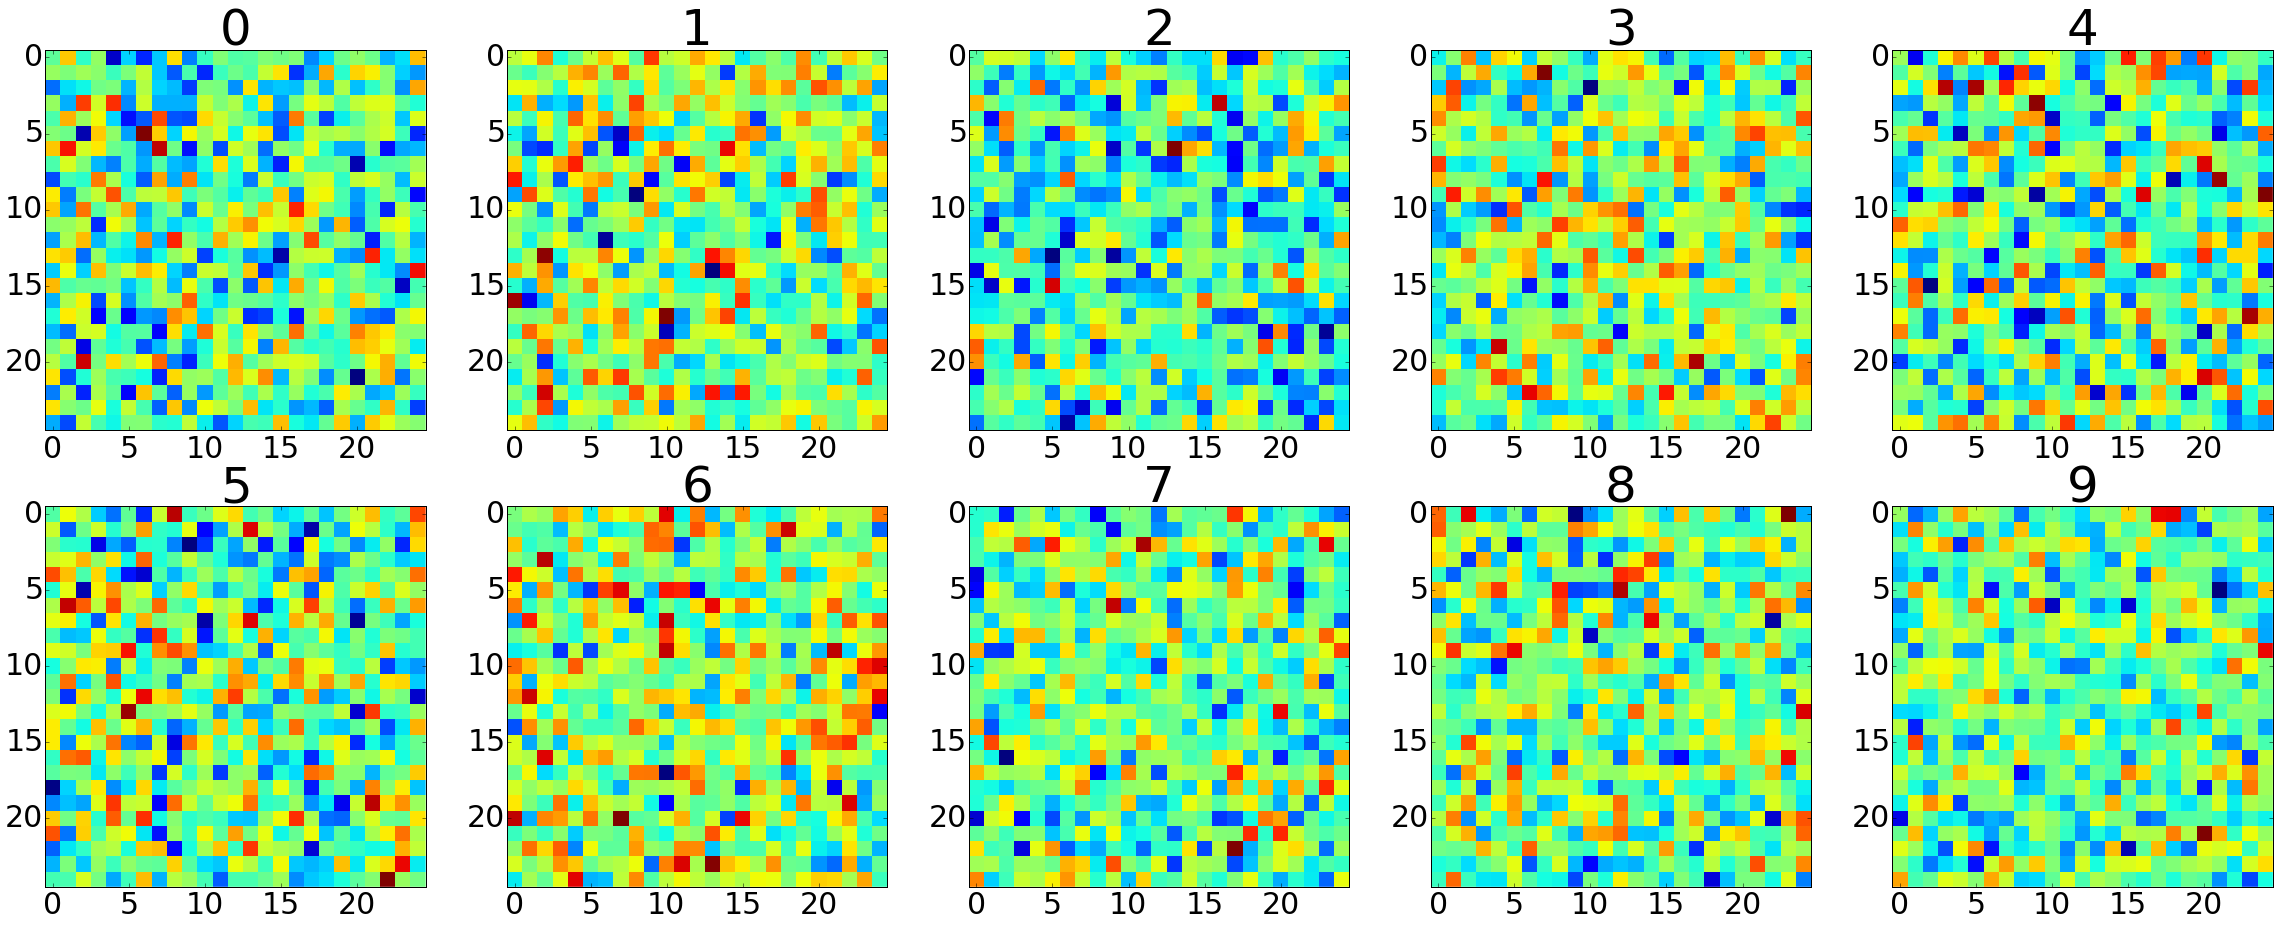

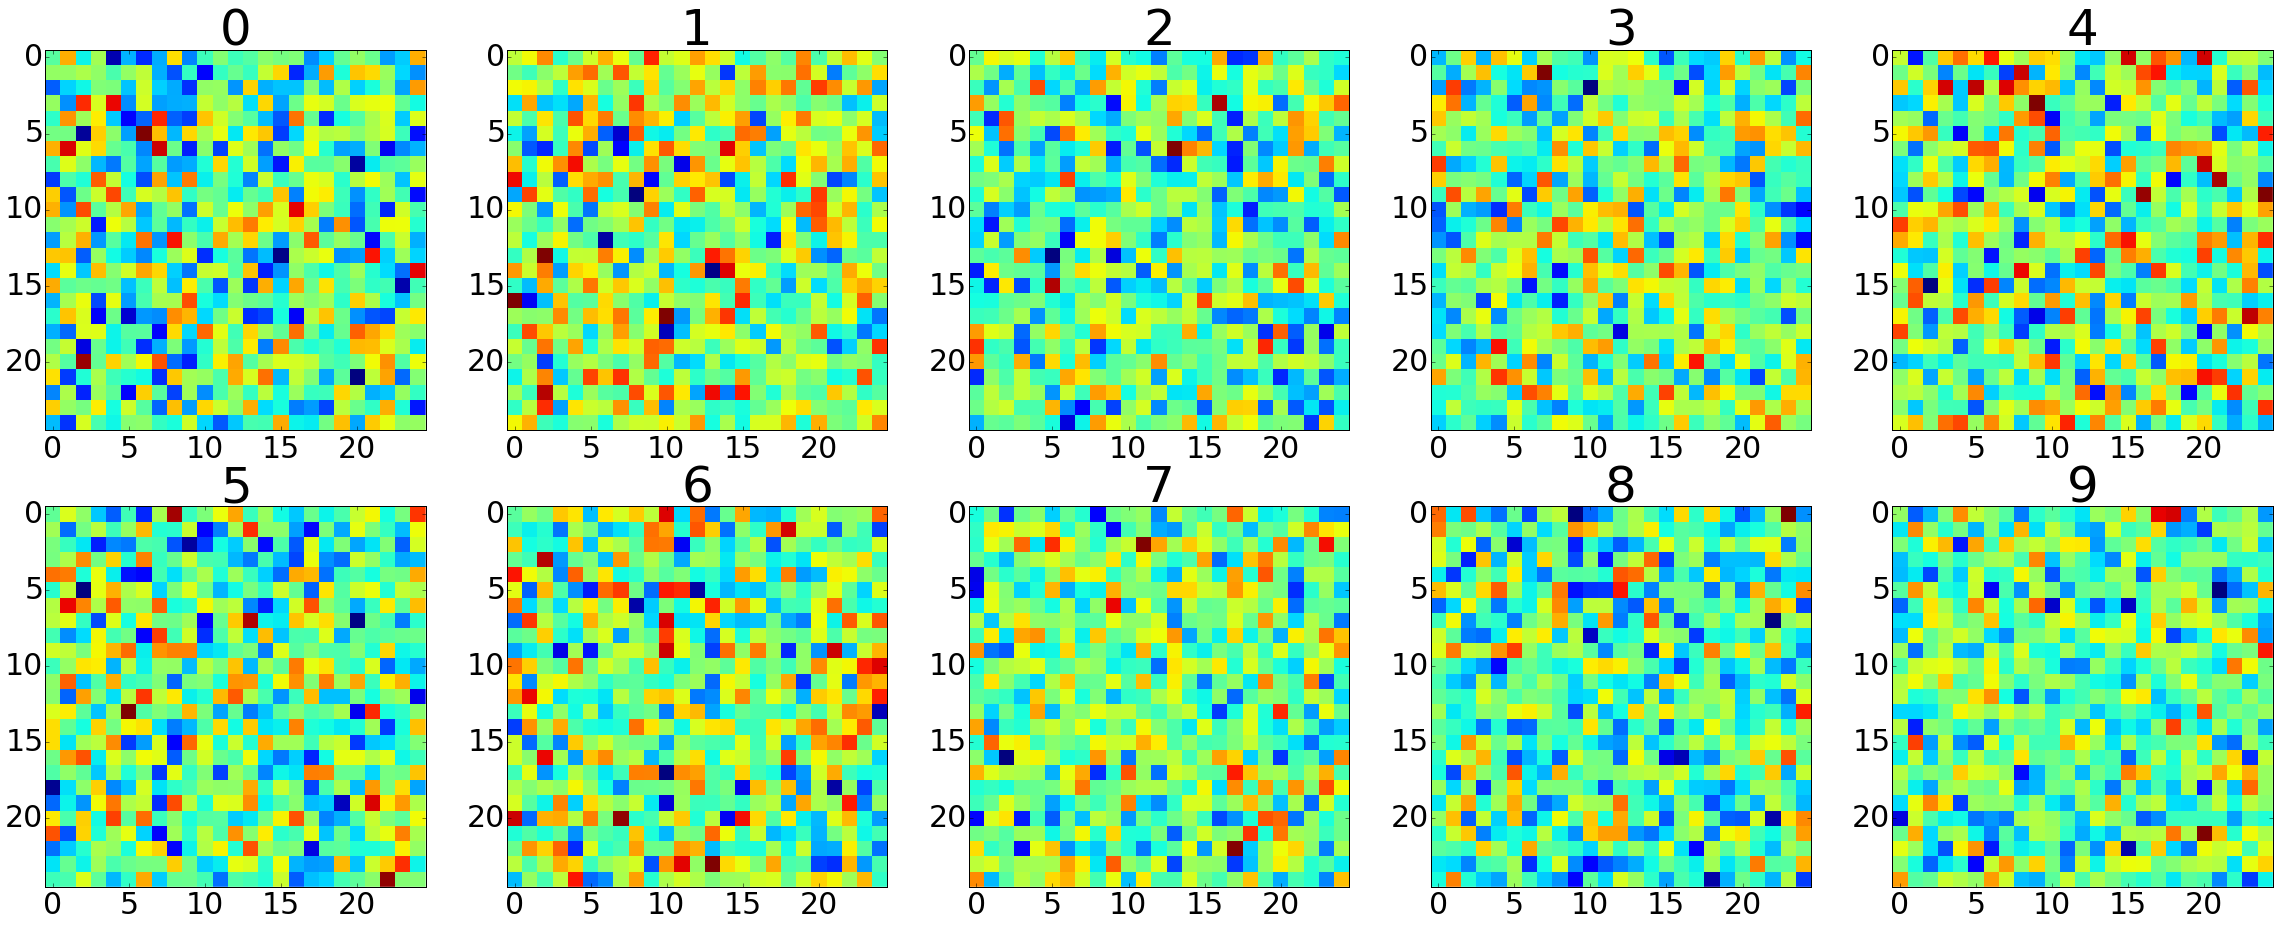

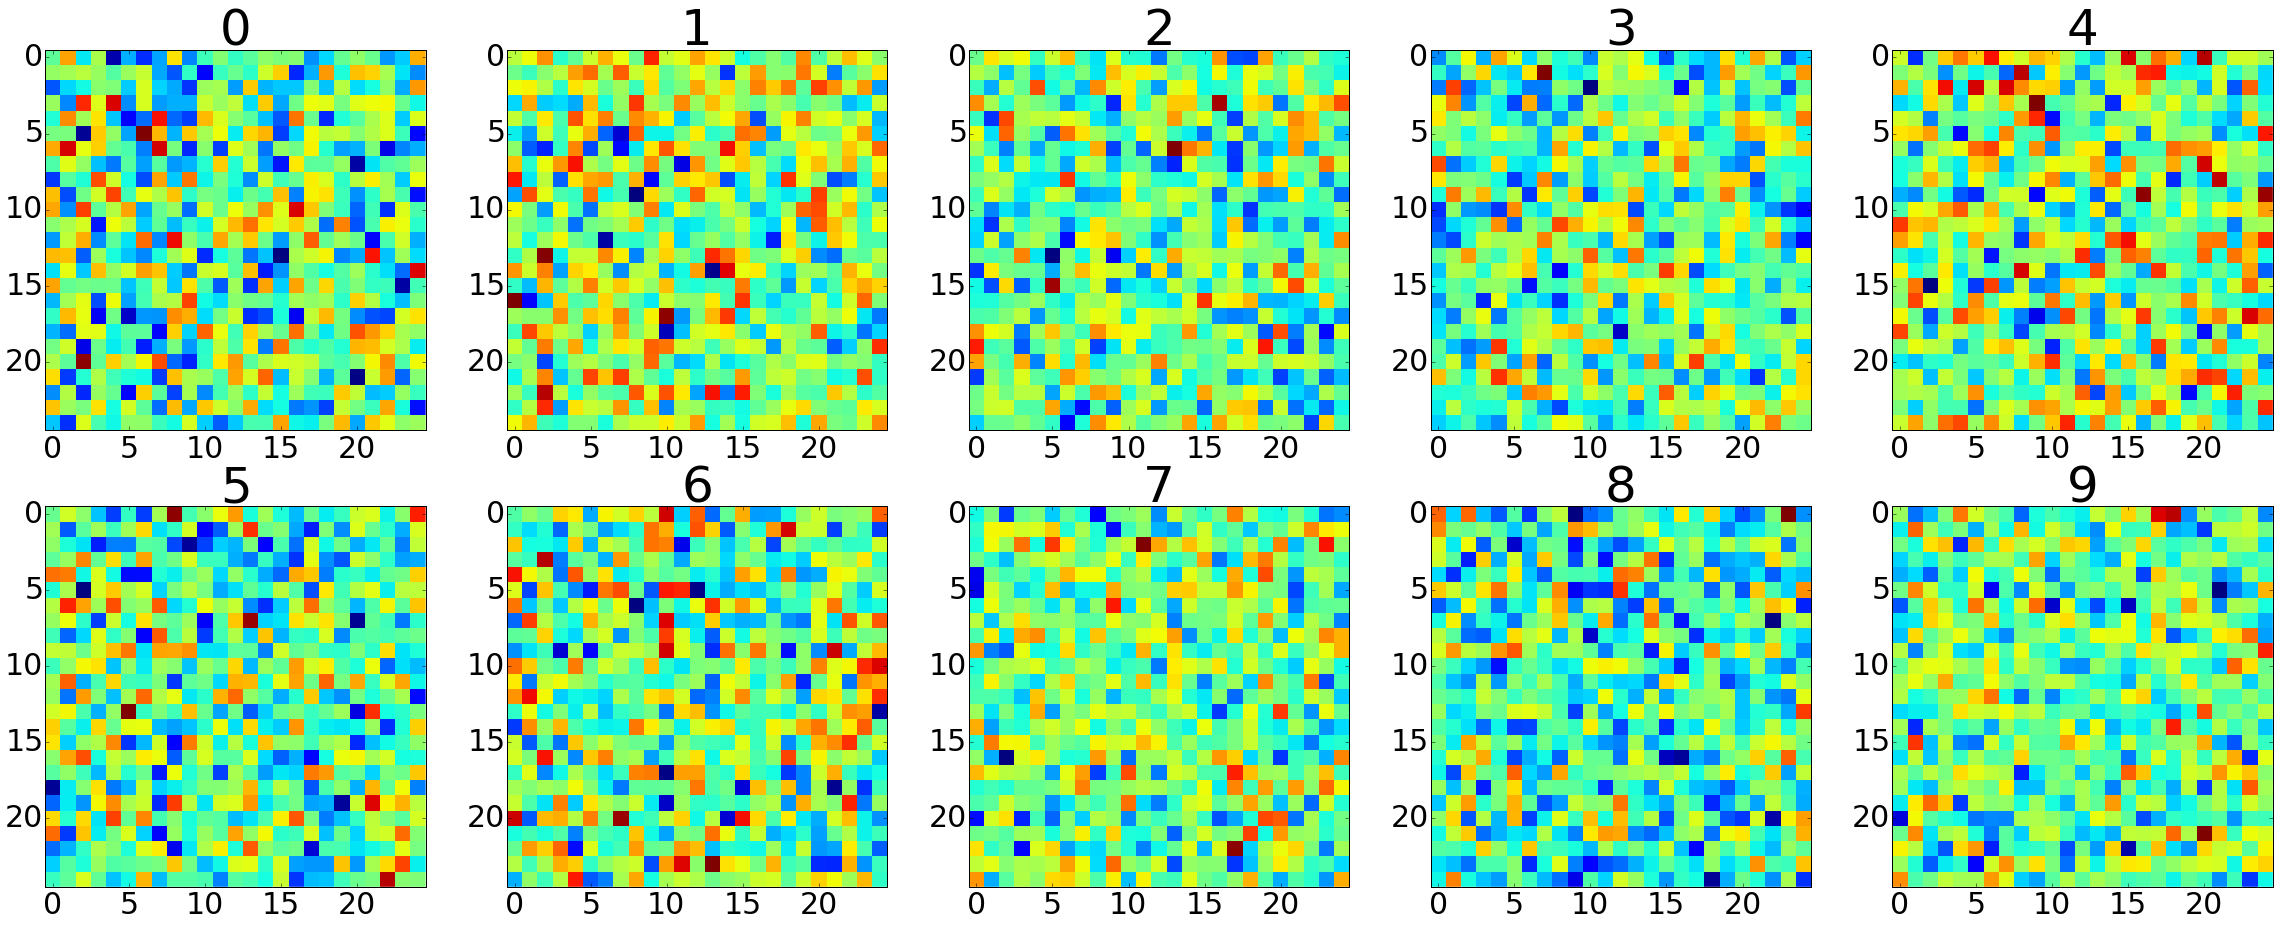

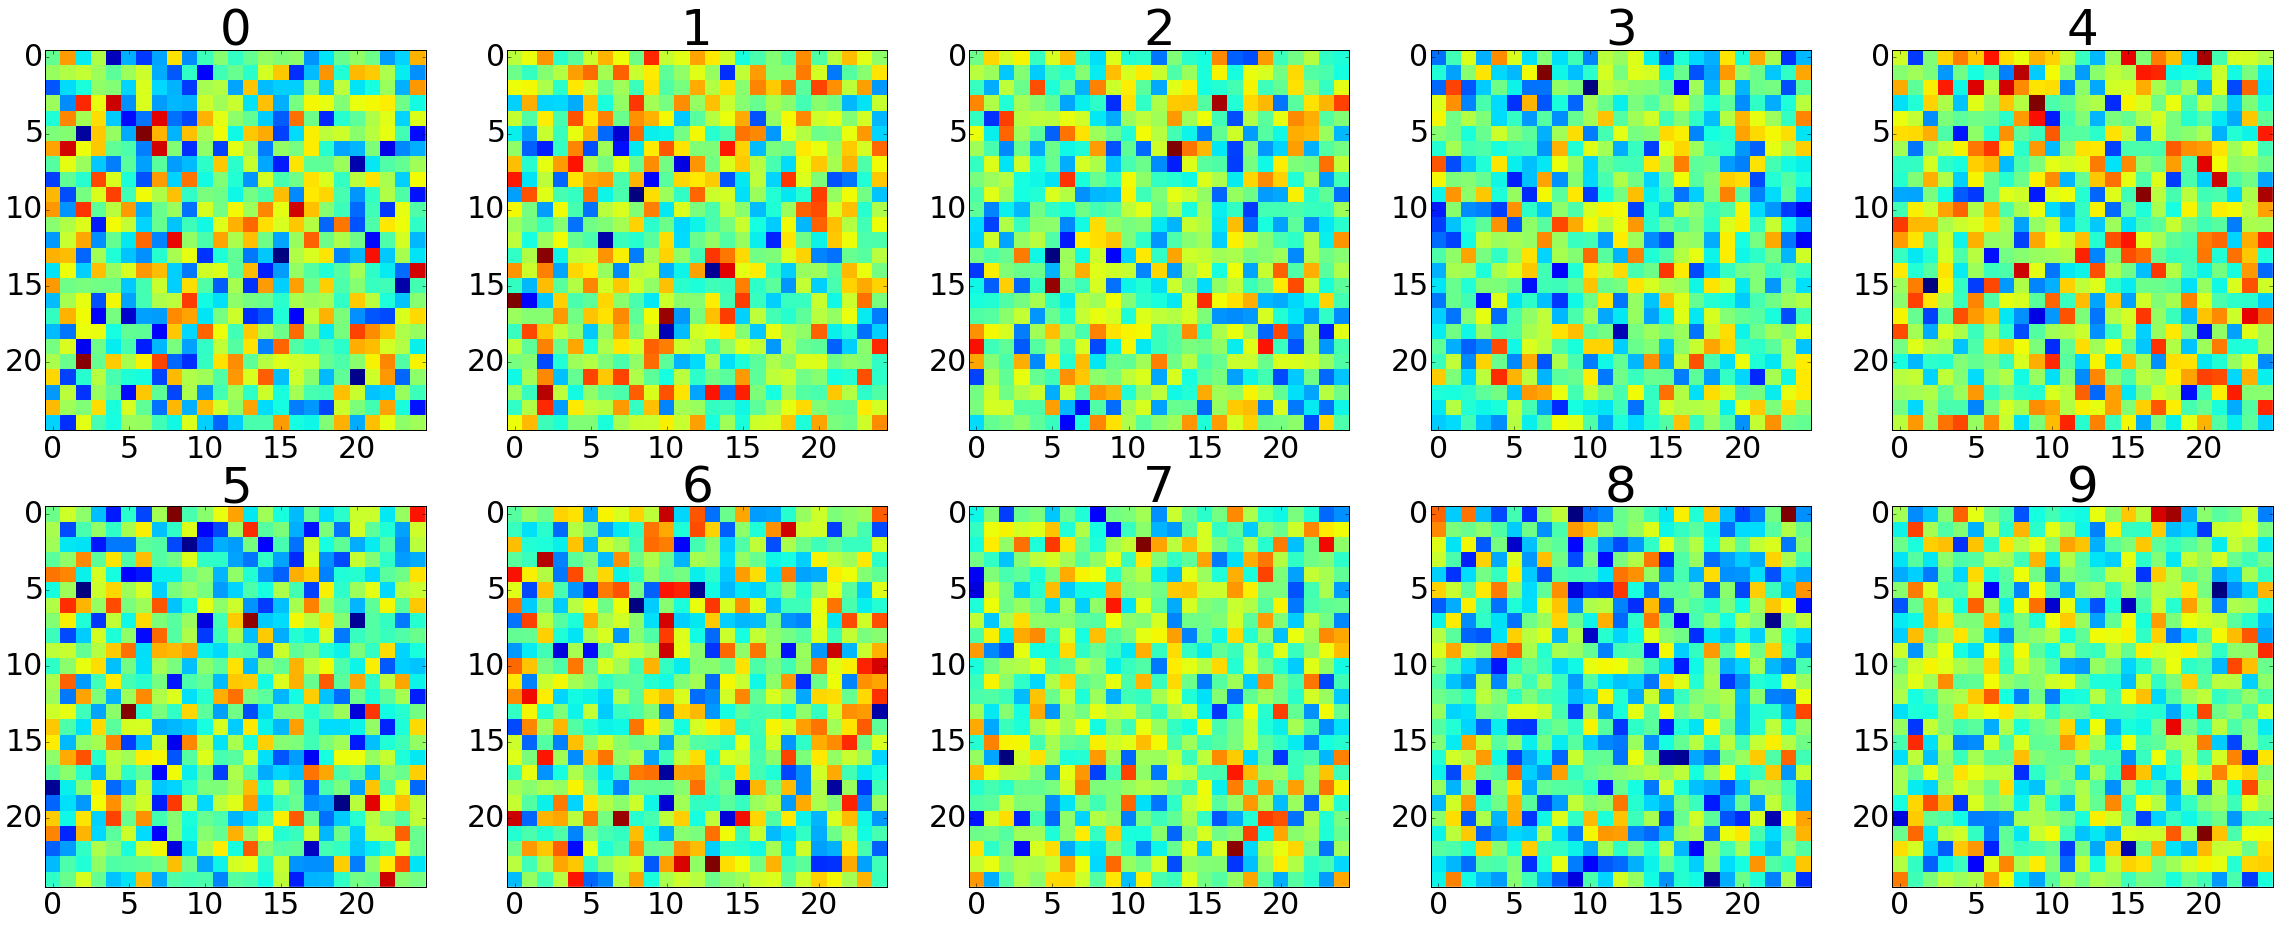

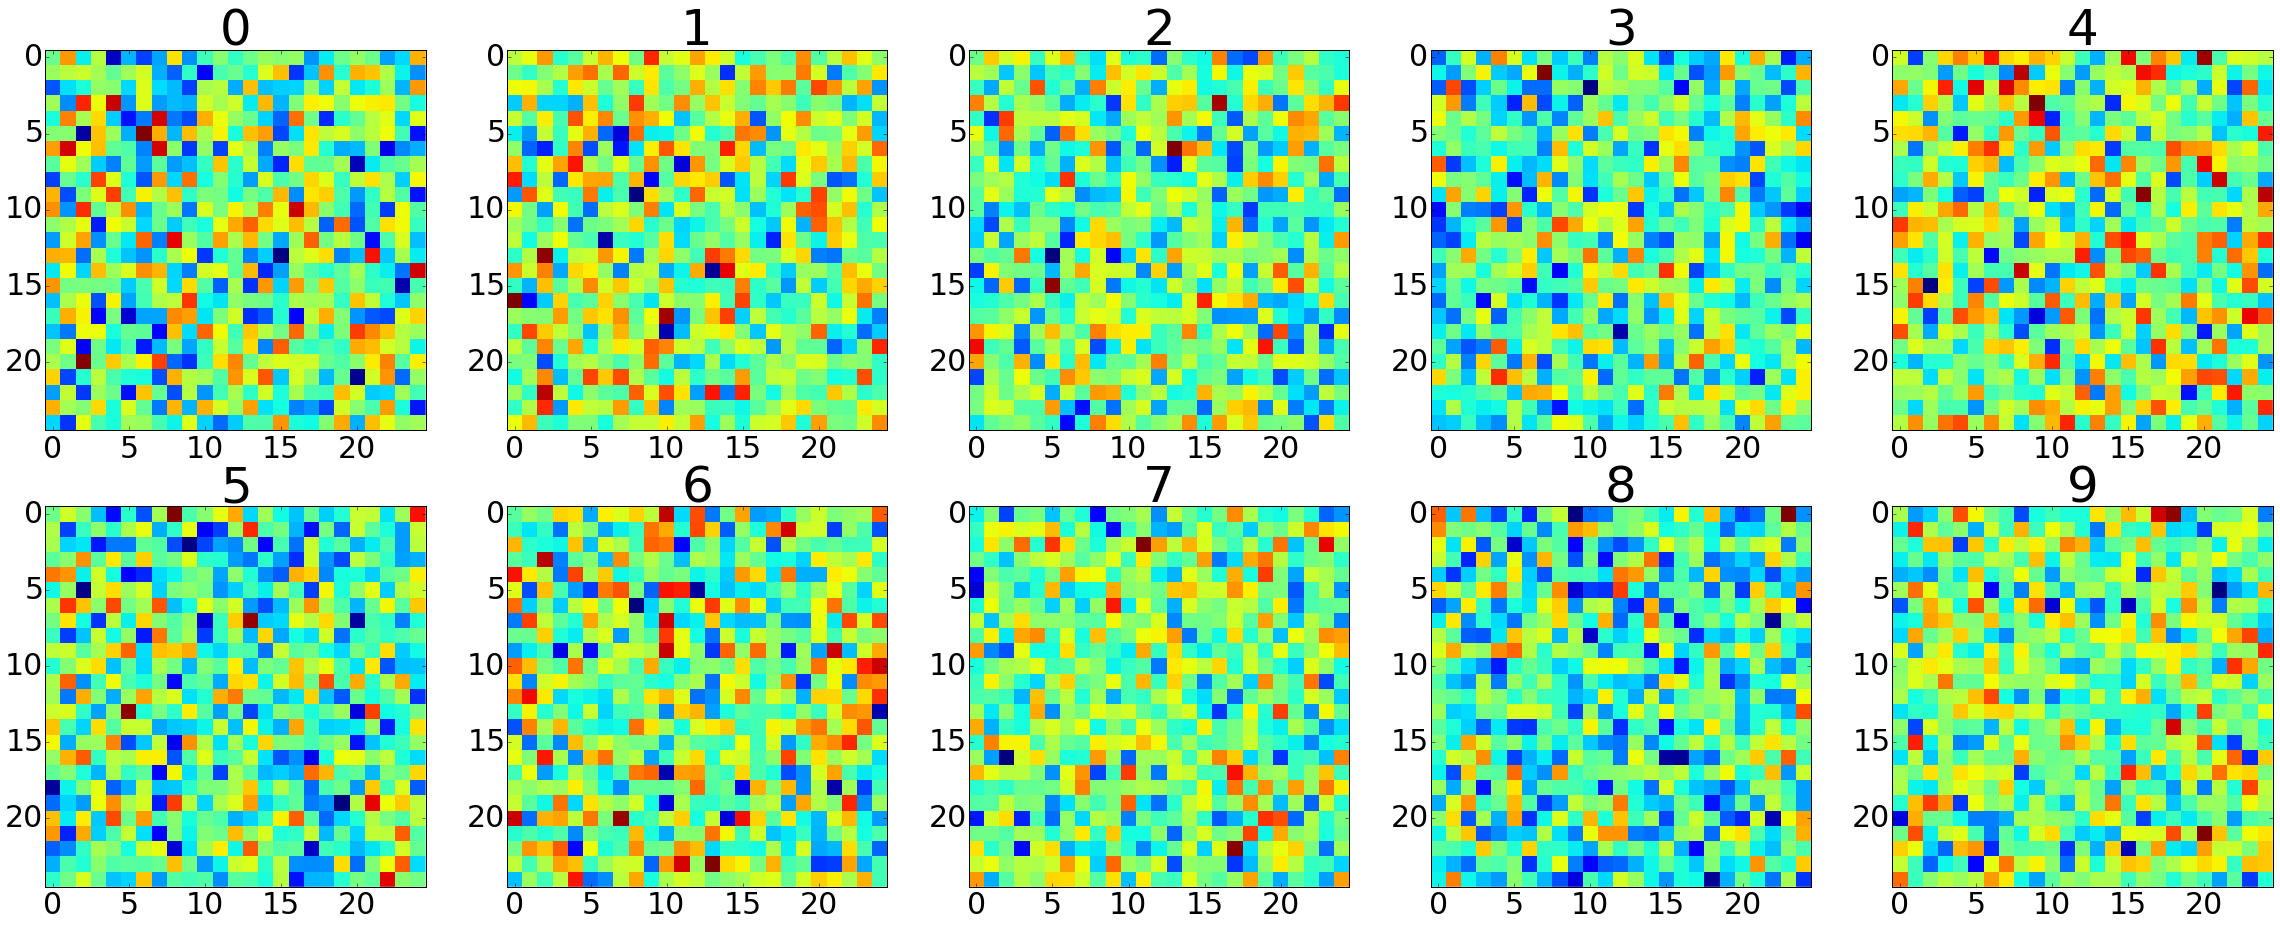

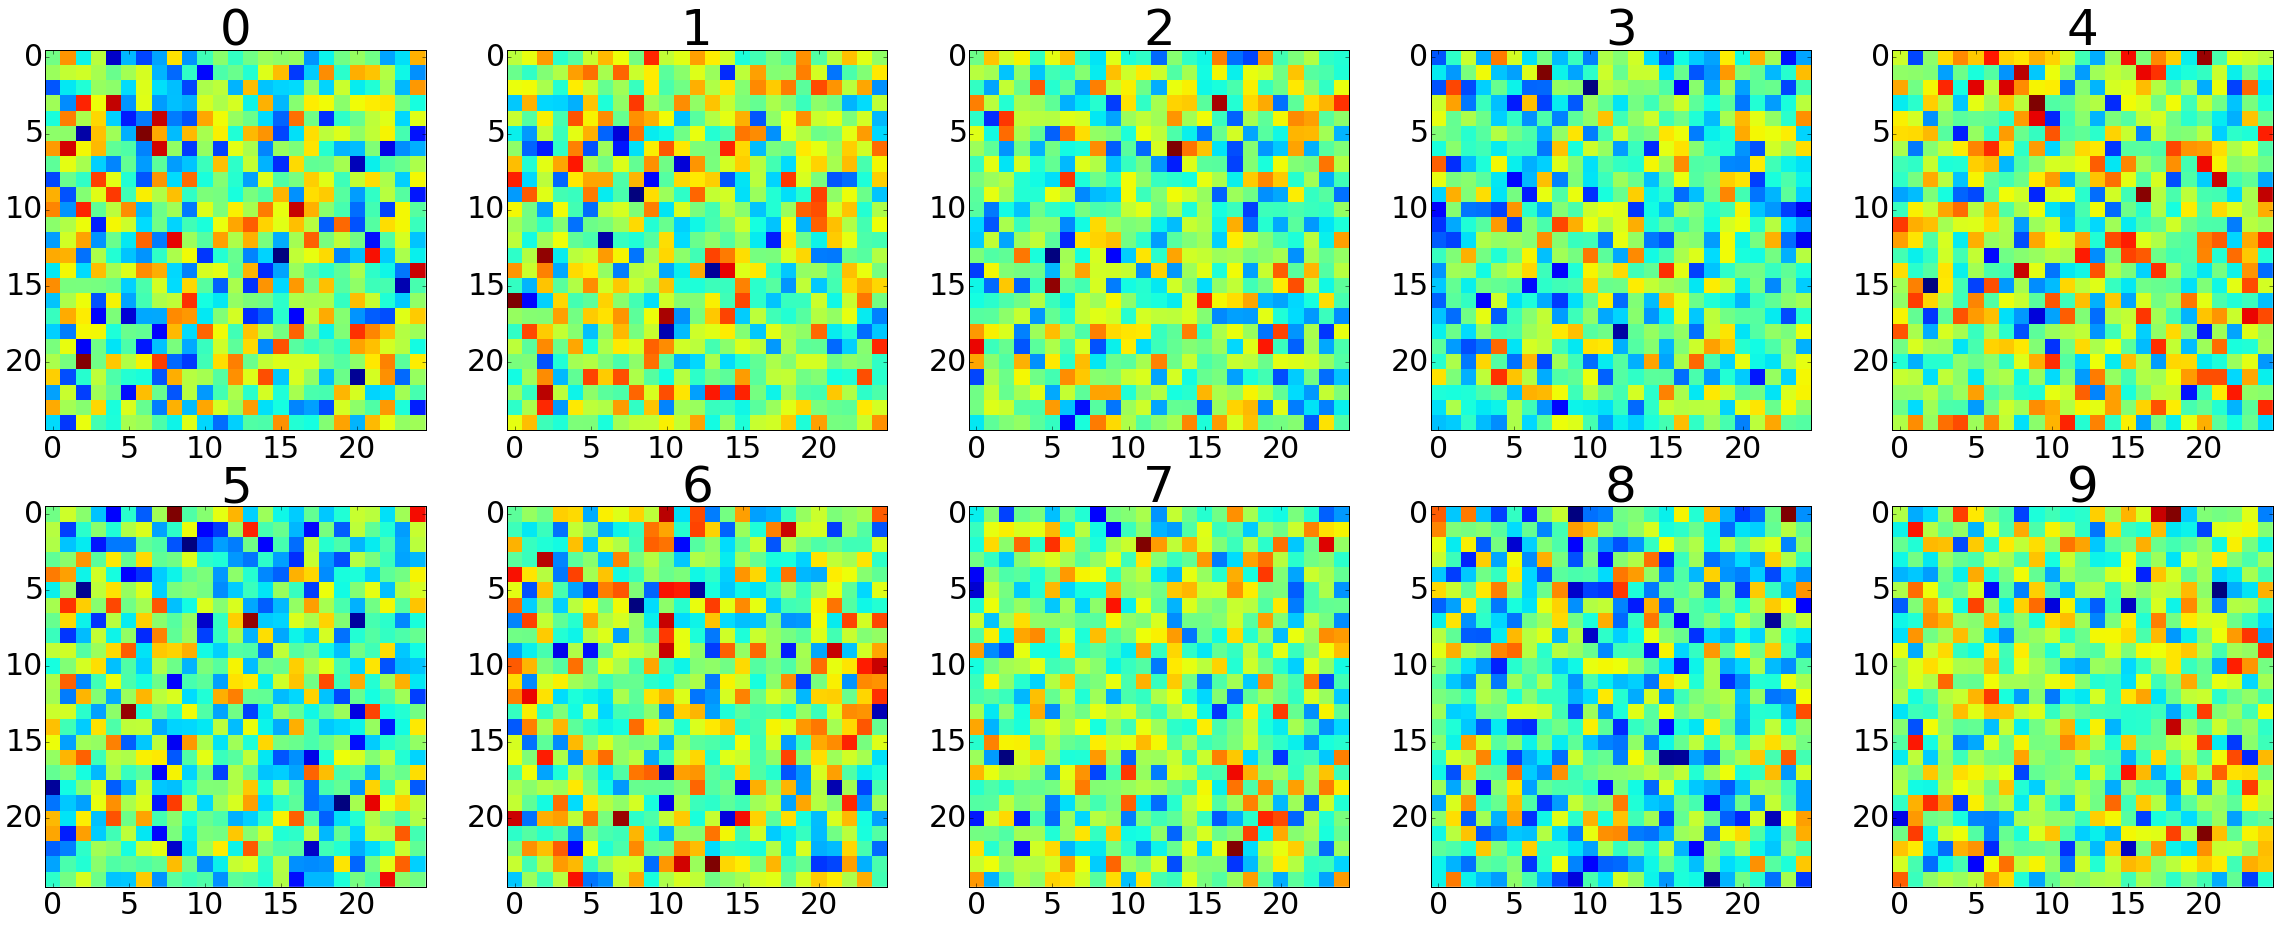

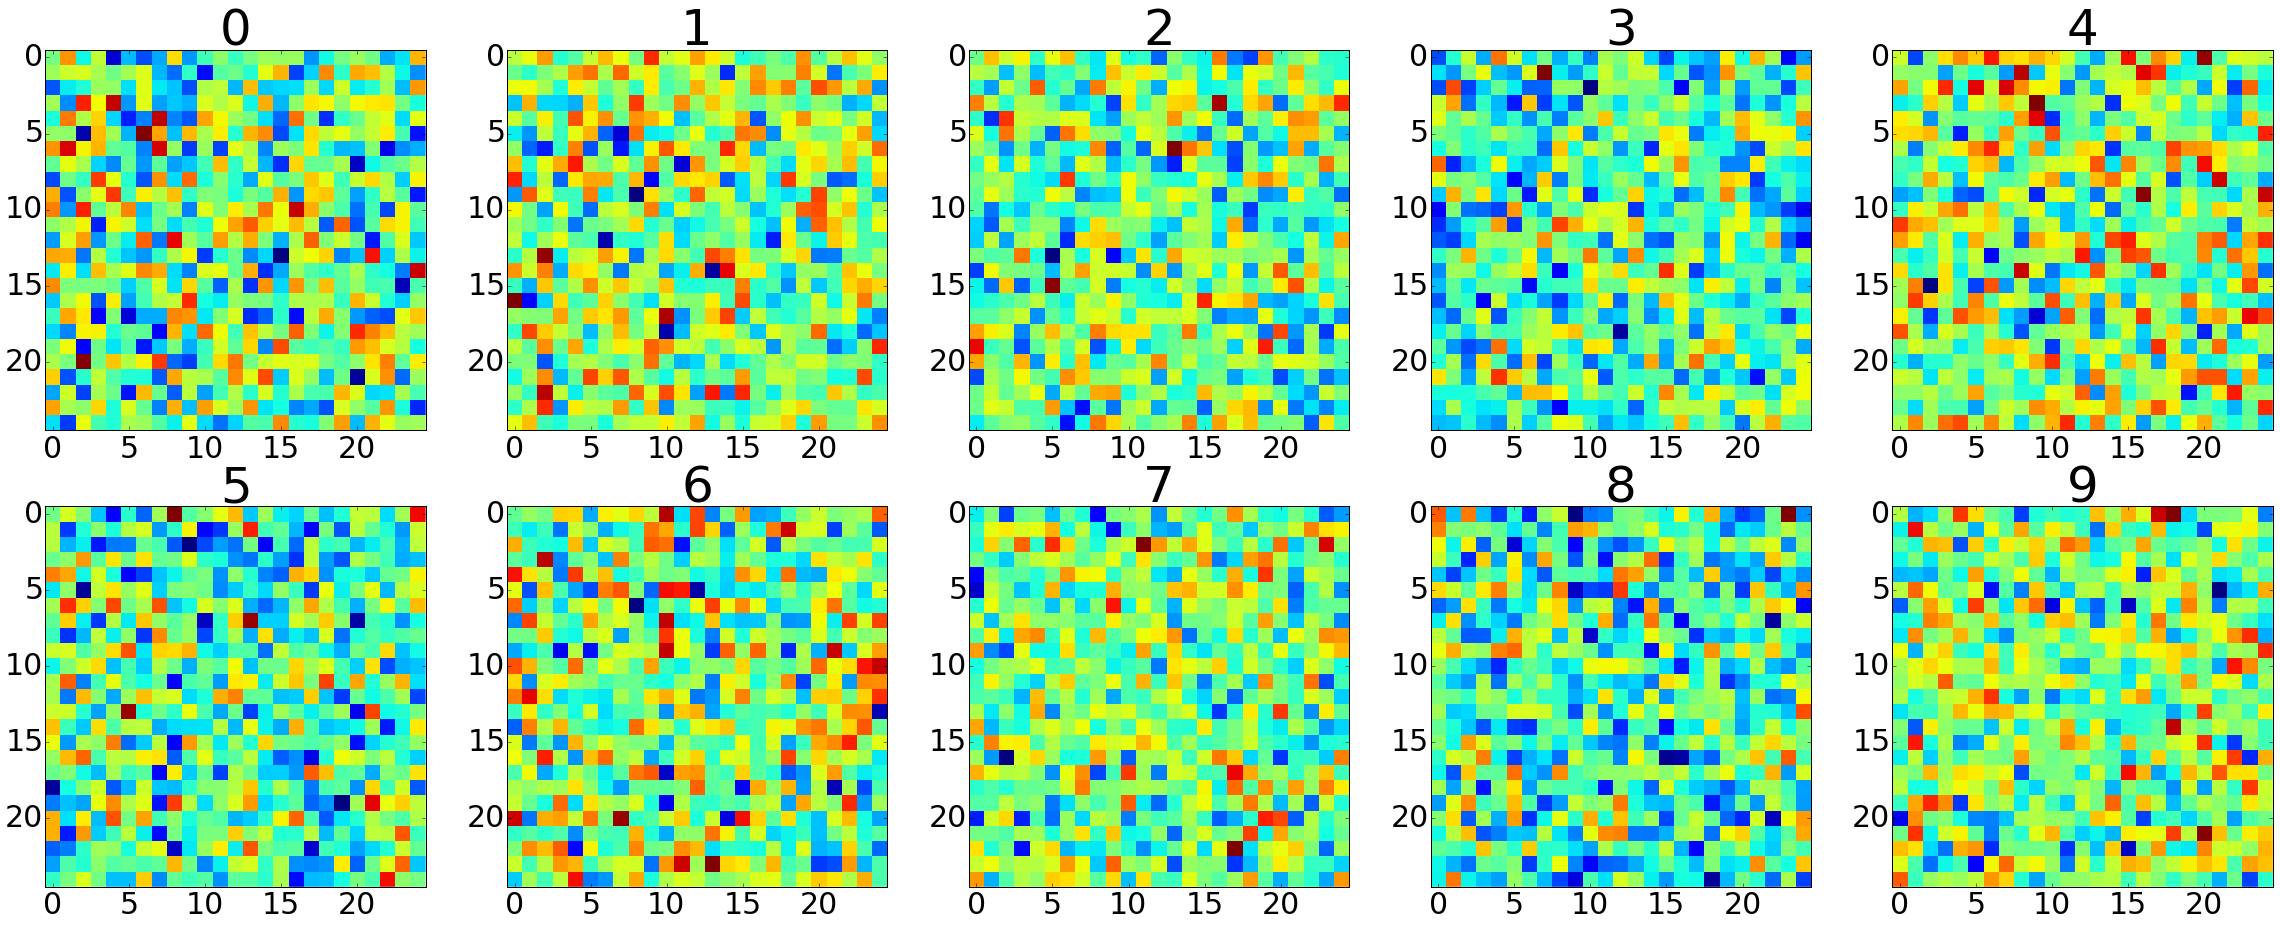

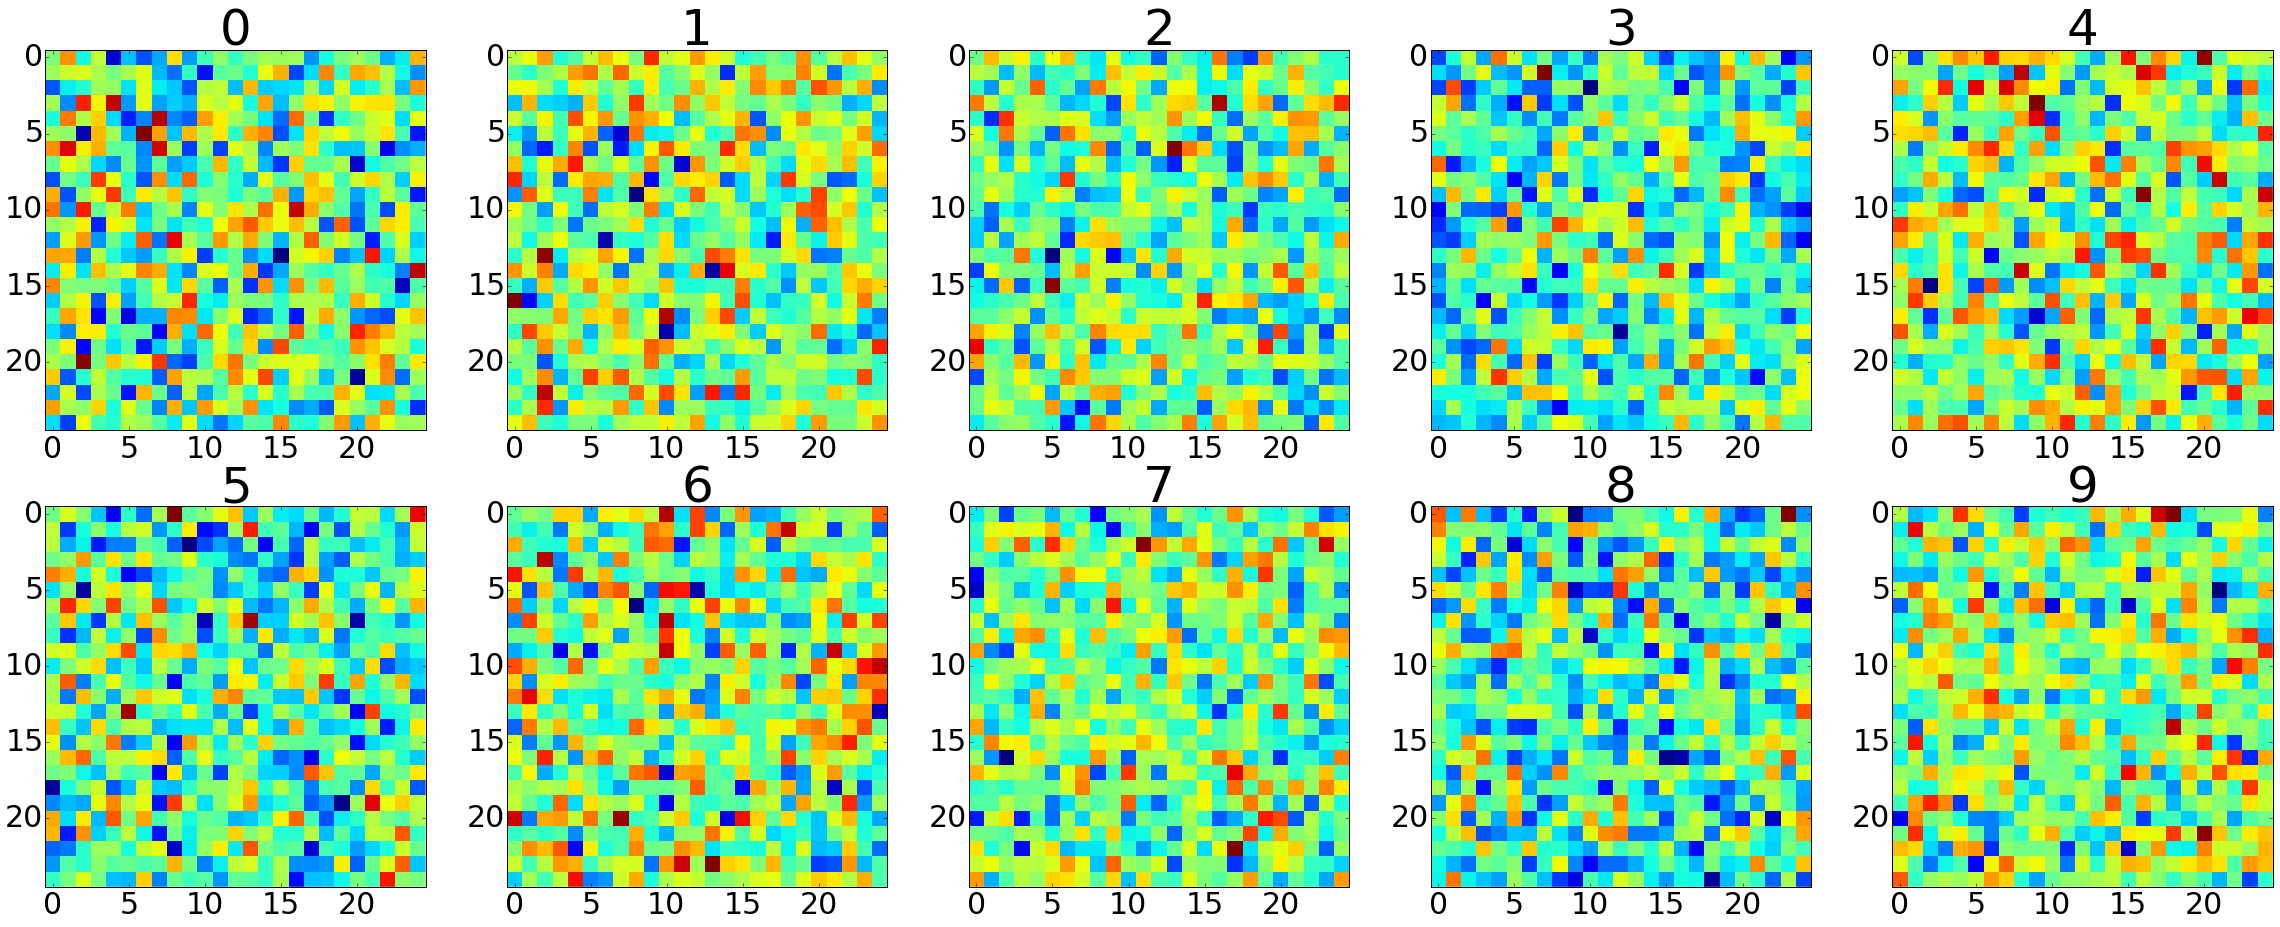

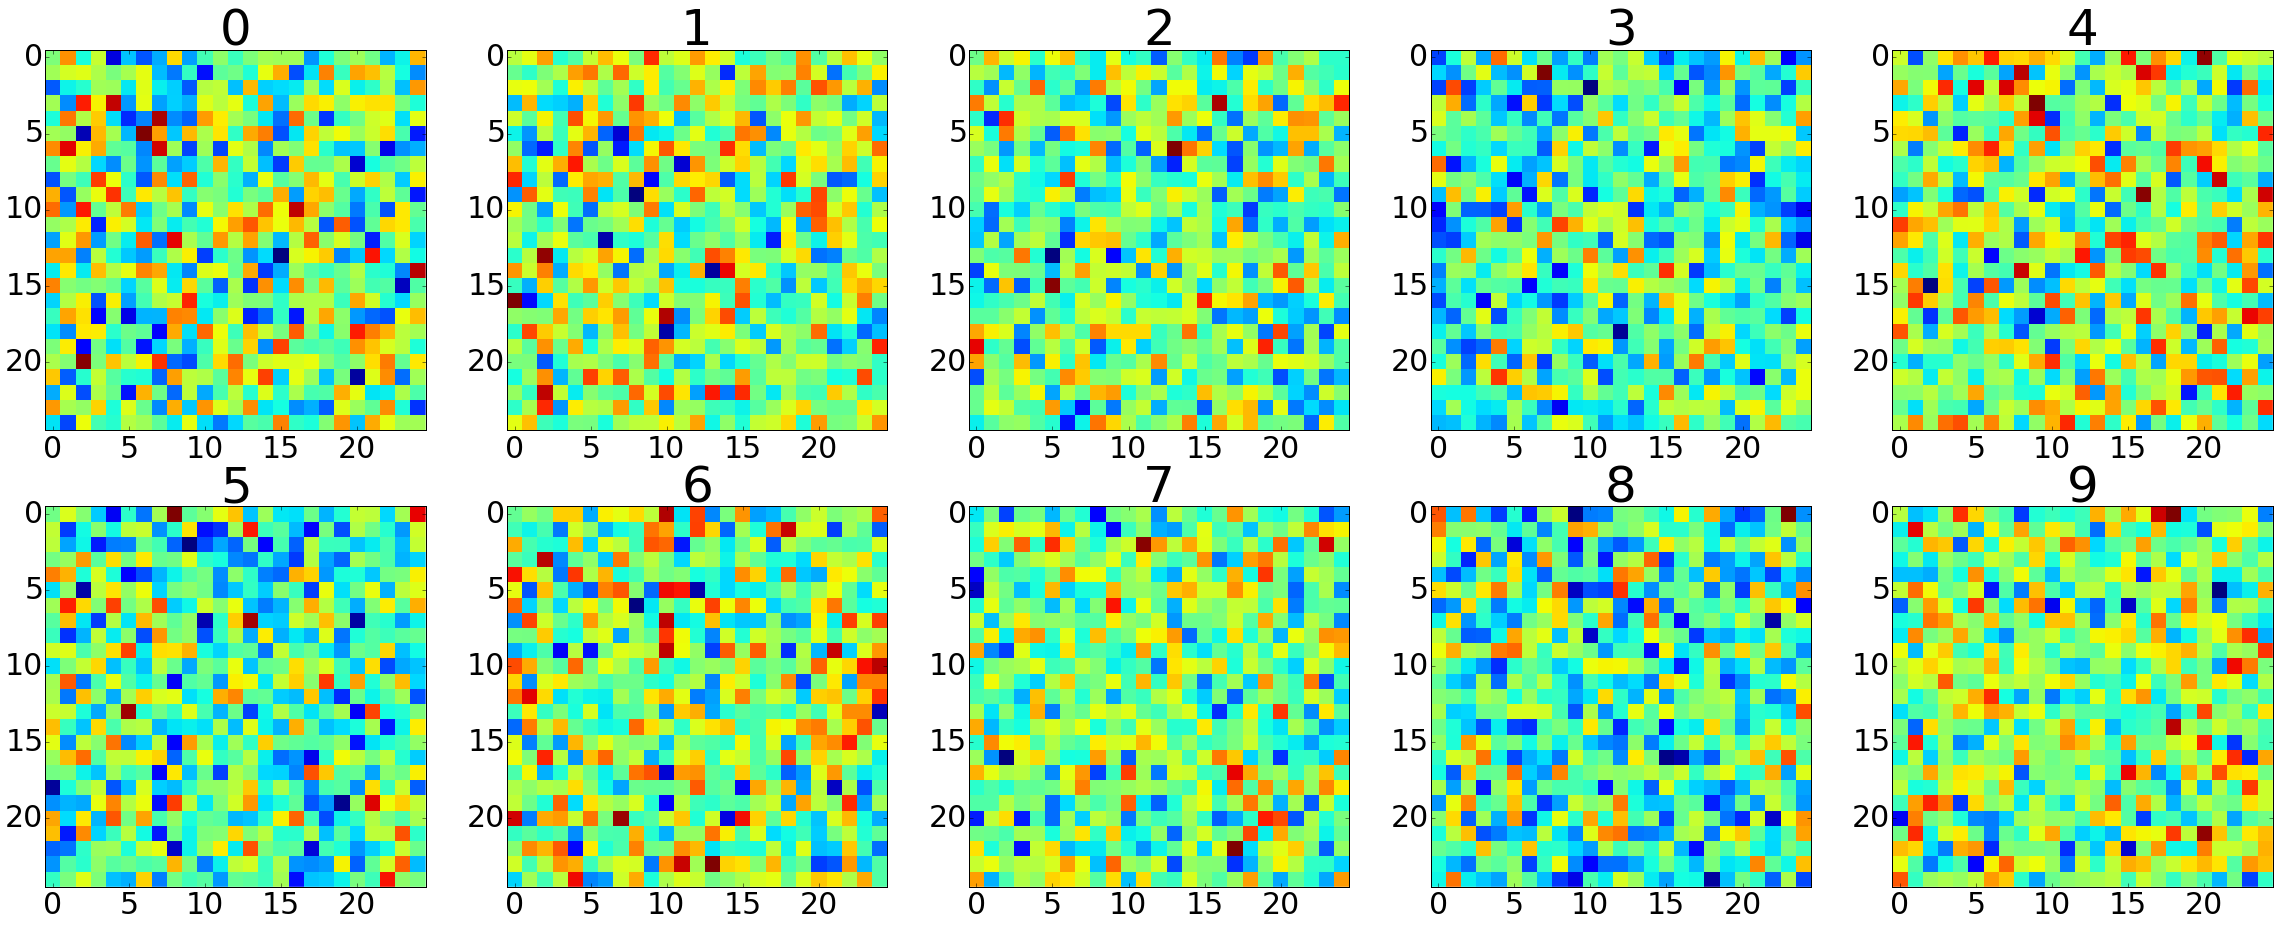

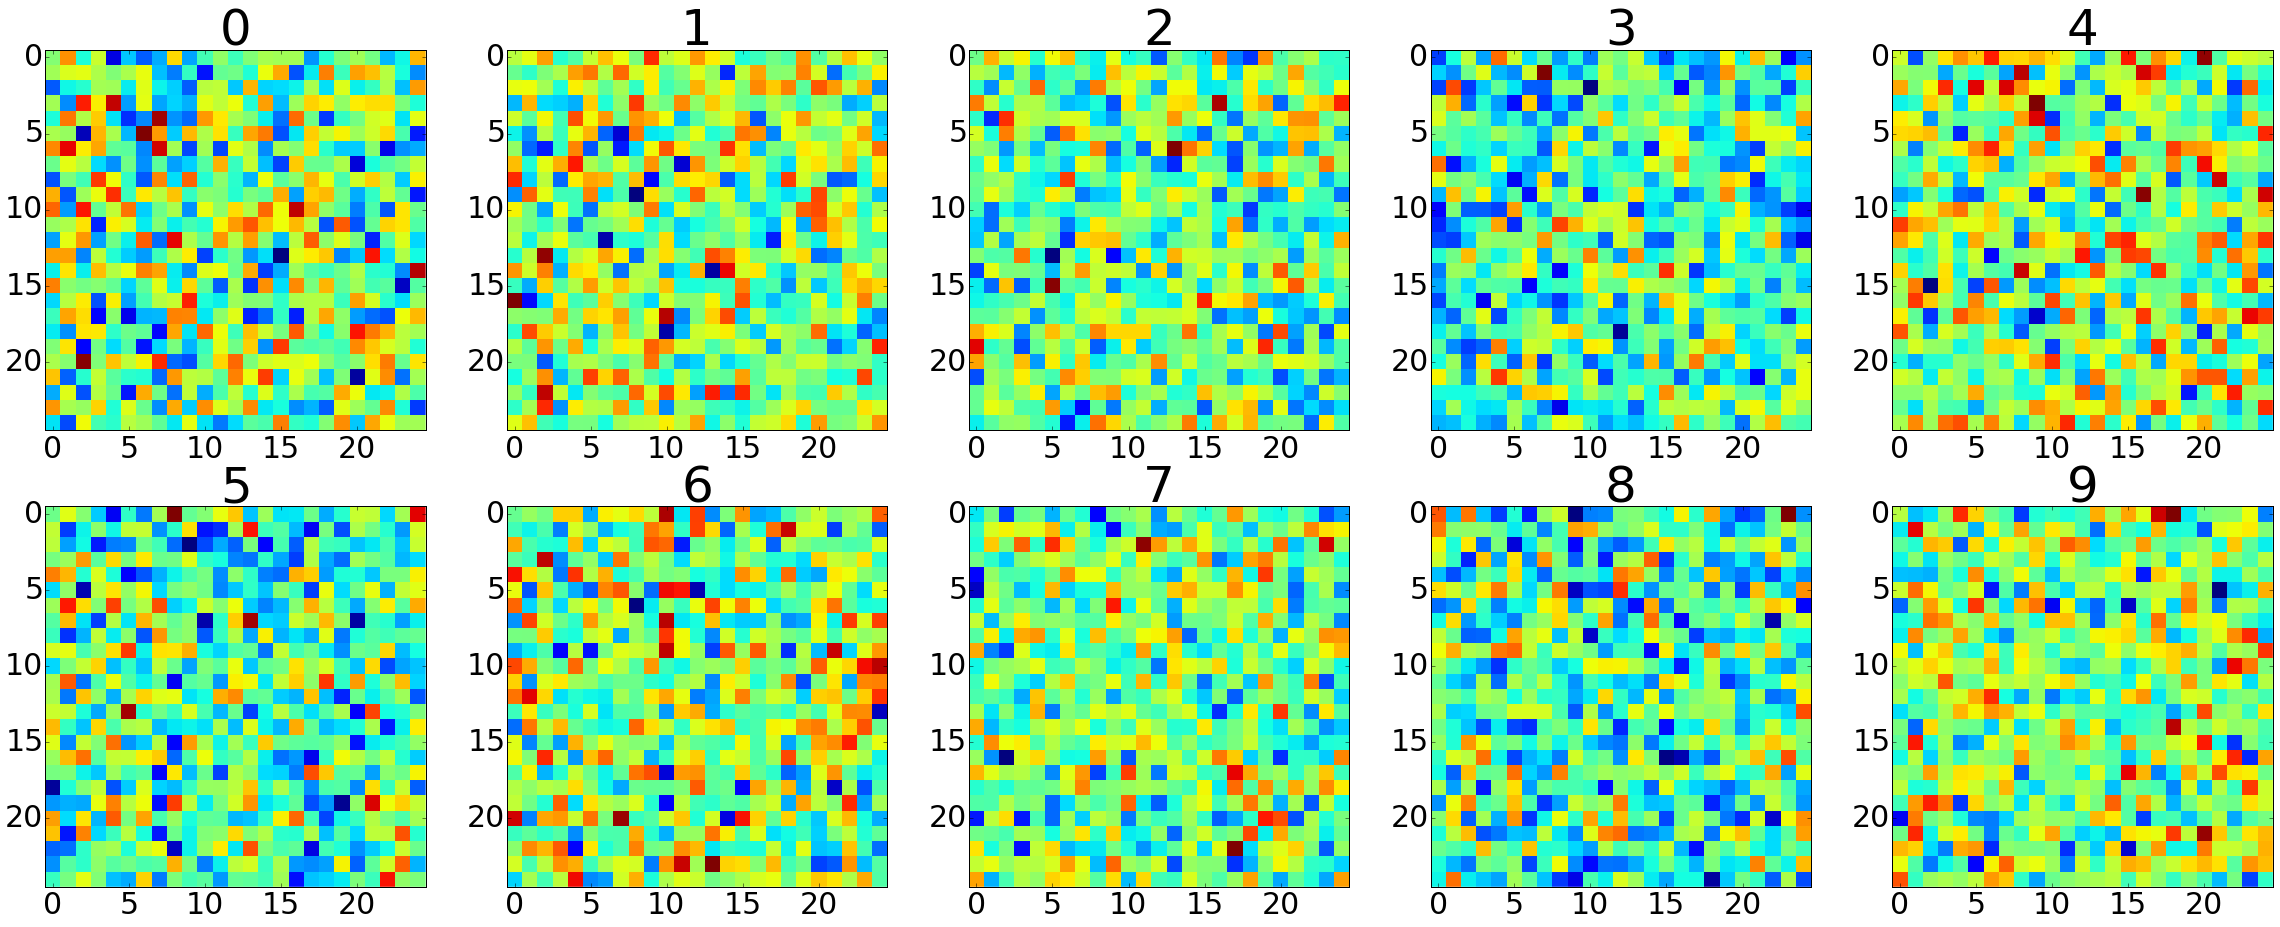

In [7]:
w_h = init_weights((784, 625))  # initialize weights for hidden layer
w_o = init_weights((625, 10))

py_x = model(X, w_h, w_o)
y_x = T.argmax(py_x, axis=1)

cost = T.mean(T.nnet.categorical_crossentropy(py_x, Y))
params = [w_h, w_o]  # the NN has 1 hidden layer and 1 output layer
updates = sgd(cost, params) # use SGD as it update function

train = theano.function(inputs=[X, Y], outputs=cost, updates=updates, allow_input_downcast=True)
predict = theano.function(inputs=[X], outputs=y_x, allow_input_downcast=True)

matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30)

for i in range(10):
    for start, end in zip(range(0, len(trX), 128), range(128, len(trX), 128)):
        cost = train(trX[start:end], trY[start:end])
    print i, np.mean(np.argmax(teY, axis=1) == predict(teX))          

Softmax [@A] ''   
 |dot [@B] ''   
   |sigmoid [@C] ''   
   | |dot [@D] ''   
   |   |<TensorType(float32, matrix)> [@E]
   |   |<TensorType(float64, matrix)> [@F]
   |<TensorType(float64, matrix)> [@G]


C:\Users\ngbach\AppData\Local\Continuum\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


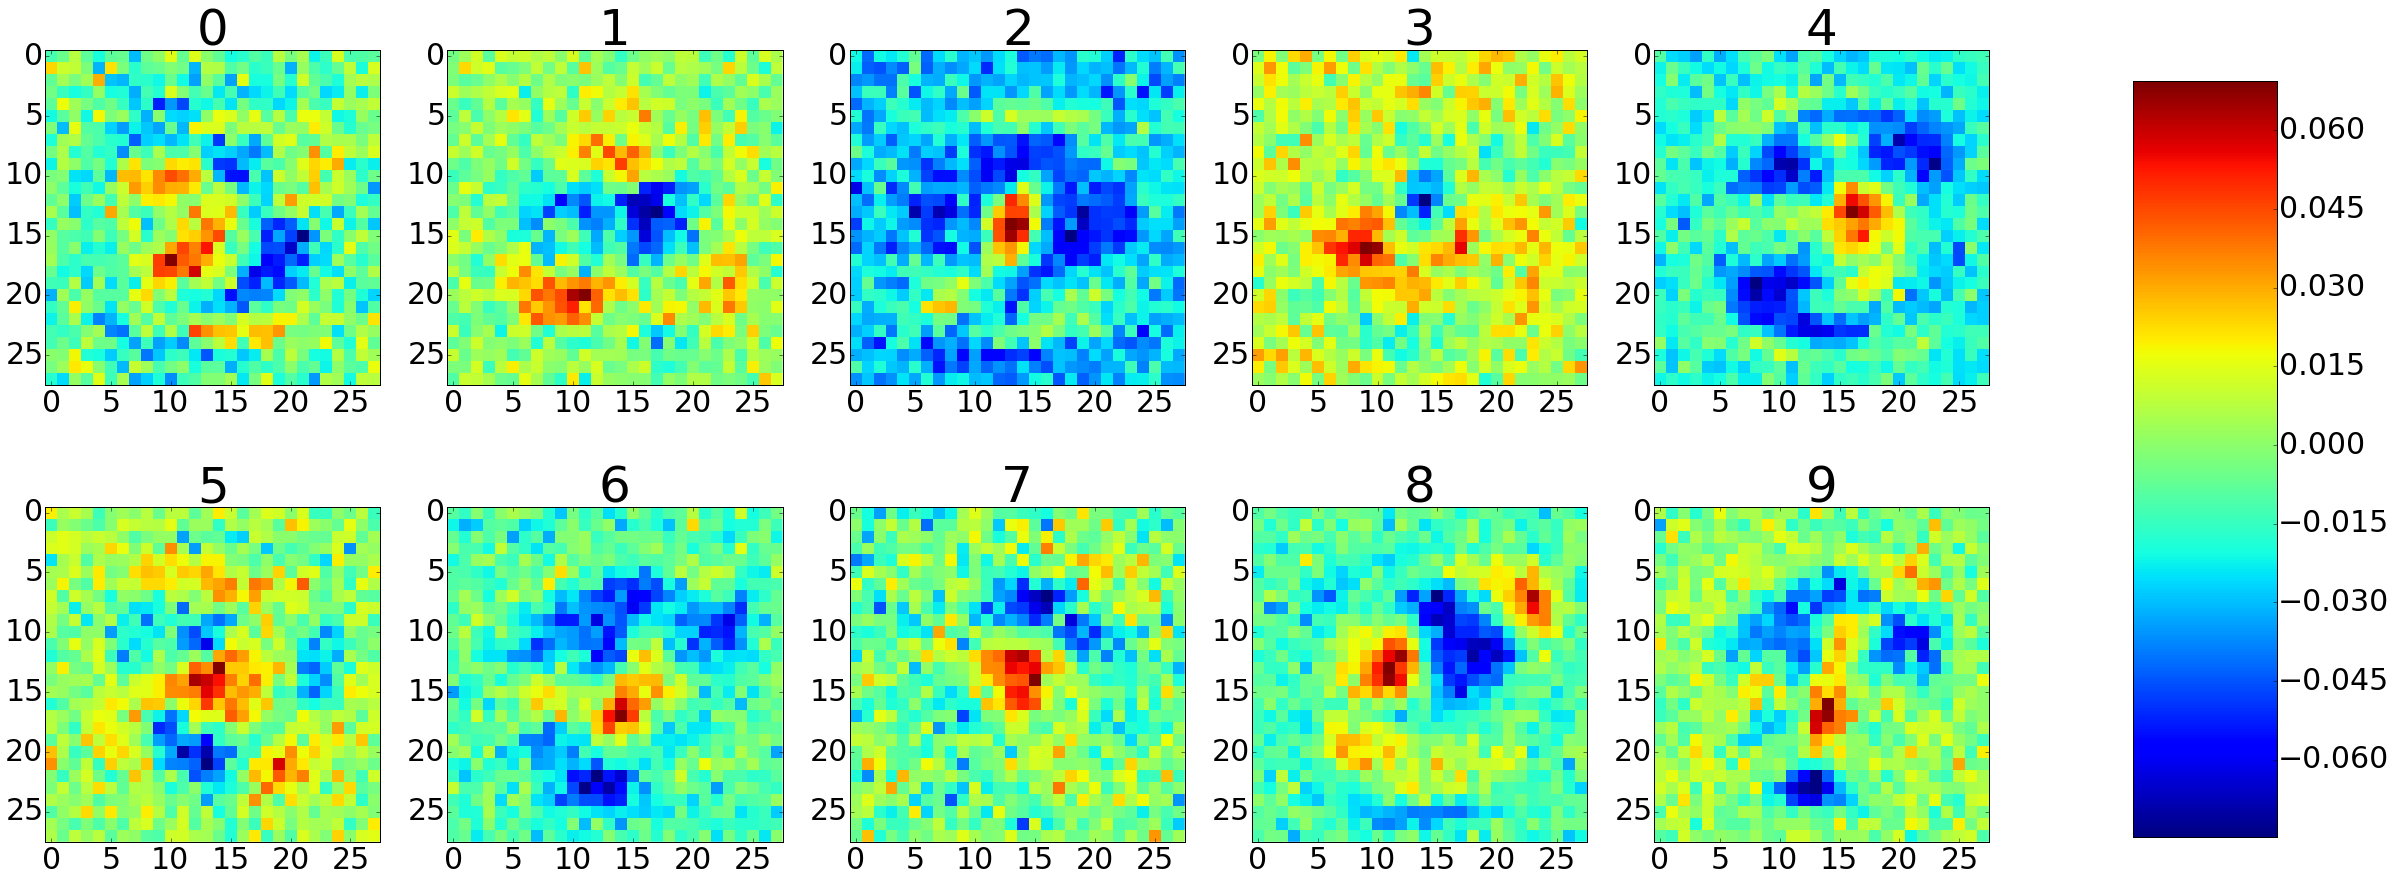

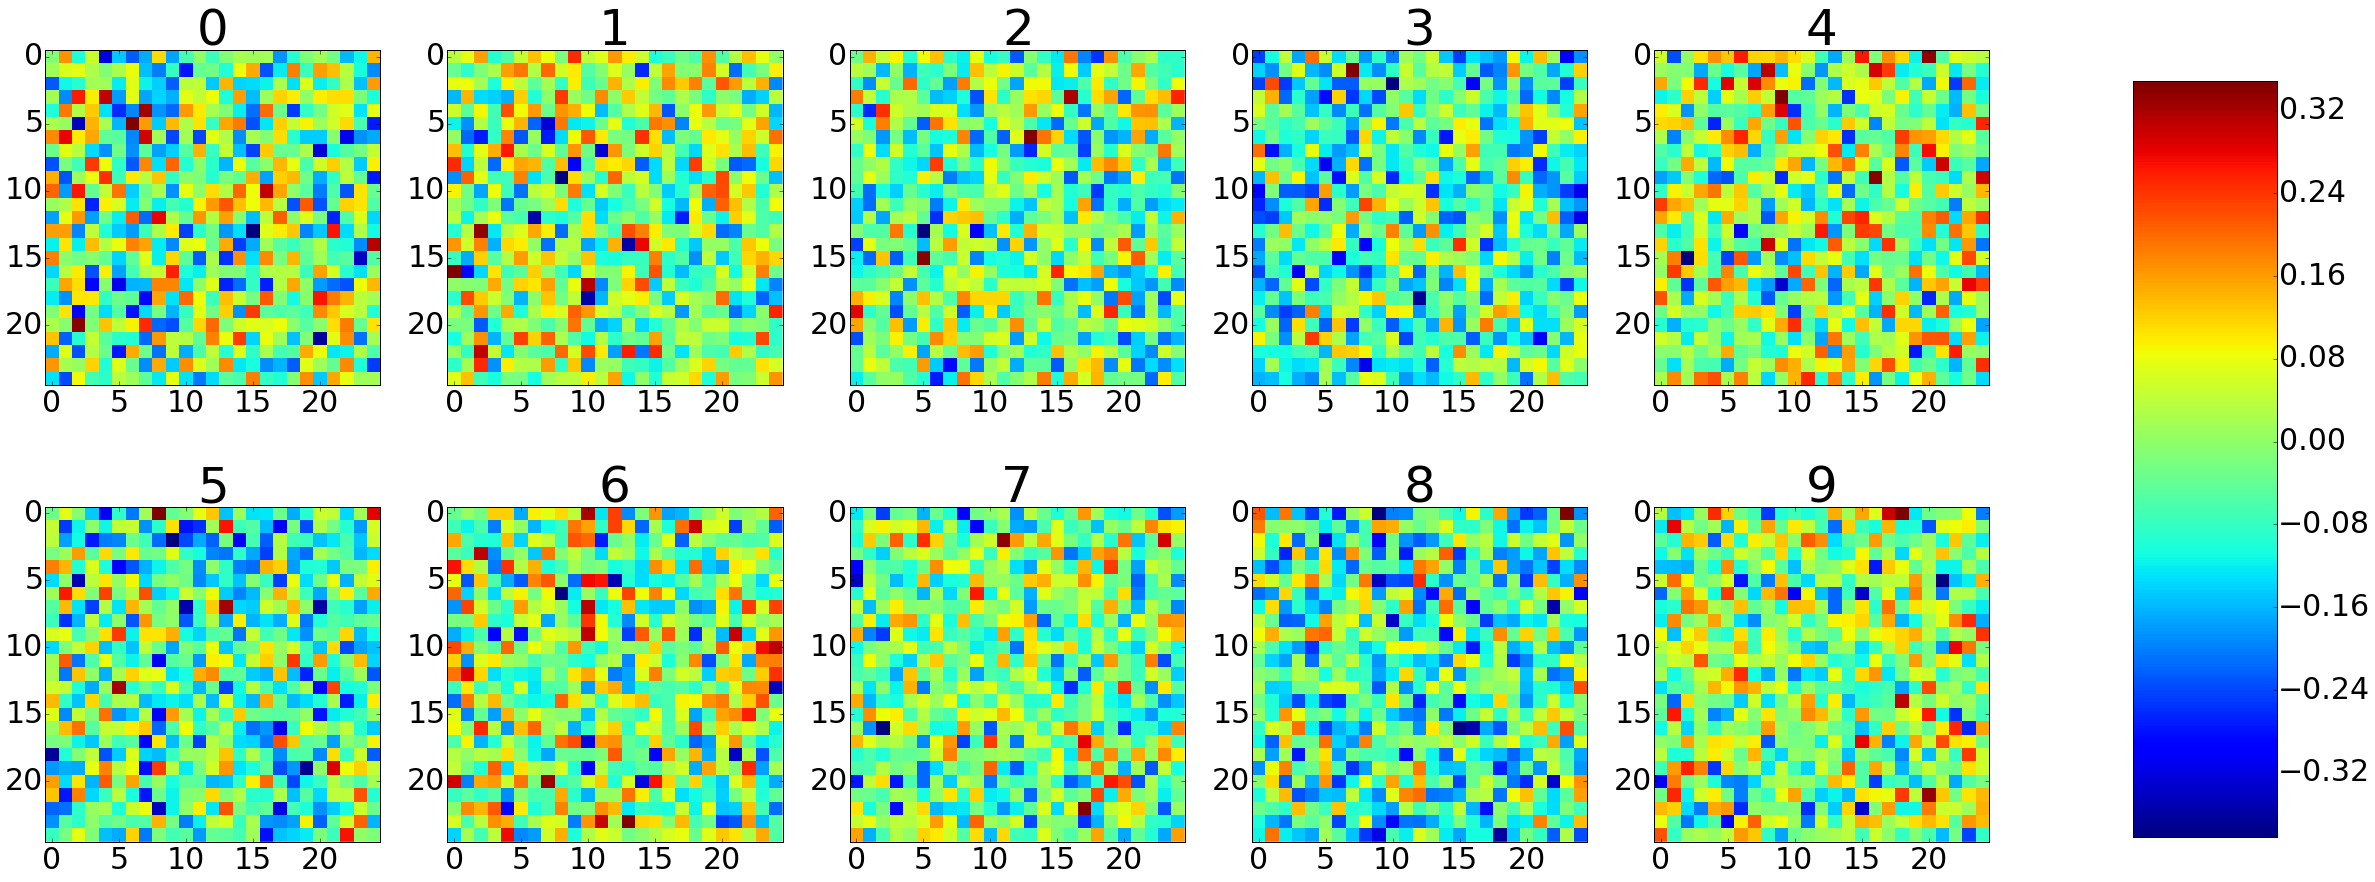

In [8]:
theano.printing.debugprint(py_x)
analyze_net(w_h, 28)
analyze_net(w_o, 25)


In [15]:
"""Modern feed forward net with 2 hiddden layers, fast update using RMSProp, 
ReLU activation function, and dropout to avoi overfitting. The architecture
as follow: 737 -> 625 -> 625 -> 10
"""
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
srng = RandomStreams()

def rectify(X):    
    return T.maximum(X, 0.)

def softmax(X):
    """numerically stable softmax"""
    e_x = T.exp(X - X.max(axis=1).dimshuffle(0, 'x'))
    return e_x / e_x.sum(axis=1).dimshuffle(0, 'x')

def RMSprop(cost, params, lr=0.001, rho=0.9, epsilon=1e-6):
    """scale the gradient"""
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        # a running average of the magnitude of the gradient
        acc = theano.shared(p.get_value() * 0.)
        acc_new = rho * acc + (1 - rho) * g ** 2
        
        # scale the gradient based on runnning average
        gradient_scaling = T.sqrt(acc_new + epsilon)
        g = g / gradient_scaling
        
        # update weights and accummulator
        updates.append((acc, acc_new))
        updates.append((p, p - lr * g))
    return updates

def dropout(X, p=0.):    
    if p > 0:
        # randomly drop values and scale rest
        retain_prob = 1 - p
        X *= srng.binomial(X.shape, p=retain_prob, dtype=theano.config.floatX)
        X /= retain_prob
    return X

def model(X, w_h, w_h2, w_o, p_drop_input, p_drop_hidden):
    X = dropout(X, p_drop_input)  # add some noise into network
    h = rectify(T.dot(X, w_h))

    h = dropout(h, p_drop_hidden)
    h2 = rectify(T.dot(h, w_h2))

    h2 = dropout(h2, p_drop_hidden)
    py_x = softmax(T.dot(h2, w_o))
    return h, h2, py_x

In [10]:
X = T.fmatrix()
Y = T.fmatrix()

w_h = init_weights((784, 625))
w_h2 = init_weights((625, 625))
w_o = init_weights((625, 10))

noise_h, noise_h2, noise_py_x = model(X, w_h, w_h2, w_o, 0.2, 0.5)
h, h2, py_x = model(X, w_h, w_h2, w_o, 0., 0.)
y_x = T.argmax(py_x, axis=1)

cost = T.mean(T.nnet.categorical_crossentropy(noise_py_x, Y))
params = [w_h, w_h2, w_o]
updates = RMSprop(cost, params, lr=0.001)

train = theano.function(inputs=[X, Y], outputs=cost, updates=updates, allow_input_downcast=True)
predict = theano.function(inputs=[X], outputs=y_x, allow_input_downcast=True)

for i in range(10):
    for start, end in zip(range(0, len(trX), 128), range(128, len(trX), 128)):
        cost = train(trX[start:end], trY[start:end])
    print i, np.mean(np.argmax(teY, axis=1) == predict(teX))

0 0.9419
1 0.9654
2 0.9737
3 0.975
4 0.9762
5 0.9766
6 0.9788
7 0.9795
8 0.9815
9 0.9802


Elemwise{true_div,no_inplace} [@A] ''   
 |Elemwise{exp,no_inplace} [@B] ''   
 | |Elemwise{sub,no_inplace} [@C] ''   
 |   |dot [@D] ''   
 |   | |Elemwise{maximum,no_inplace} [@E] ''   
 |   | | |dot [@F] ''   
 |   | | | |Elemwise{maximum,no_inplace} [@G] ''   
 |   | | | | |dot [@H] ''   
 |   | | | | | |<TensorType(float32, matrix)> [@I]
 |   | | | | | |<TensorType(float64, matrix)> [@J]
 |   | | | | |DimShuffle{x,x} [@K] ''   
 |   | | | |   |TensorConstant{0.0} [@L]
 |   | | | |<TensorType(float64, matrix)> [@M]
 |   | | |DimShuffle{x,x} [@N] ''   
 |   | |   |TensorConstant{0.0} [@L]
 |   | |<TensorType(float64, matrix)> [@O]
 |   |DimShuffle{0,x} [@P] ''   
 |     |MaxAndArgmax.0 [@Q] 'max'   
 |       |dot [@D] ''   
 |       |TensorConstant{1} [@R]
 |DimShuffle{0,x} [@S] ''   
   |Sum{axis=[1], acc_dtype=float64} [@T] ''   
     |Elemwise{exp,no_inplace} [@B] ''   


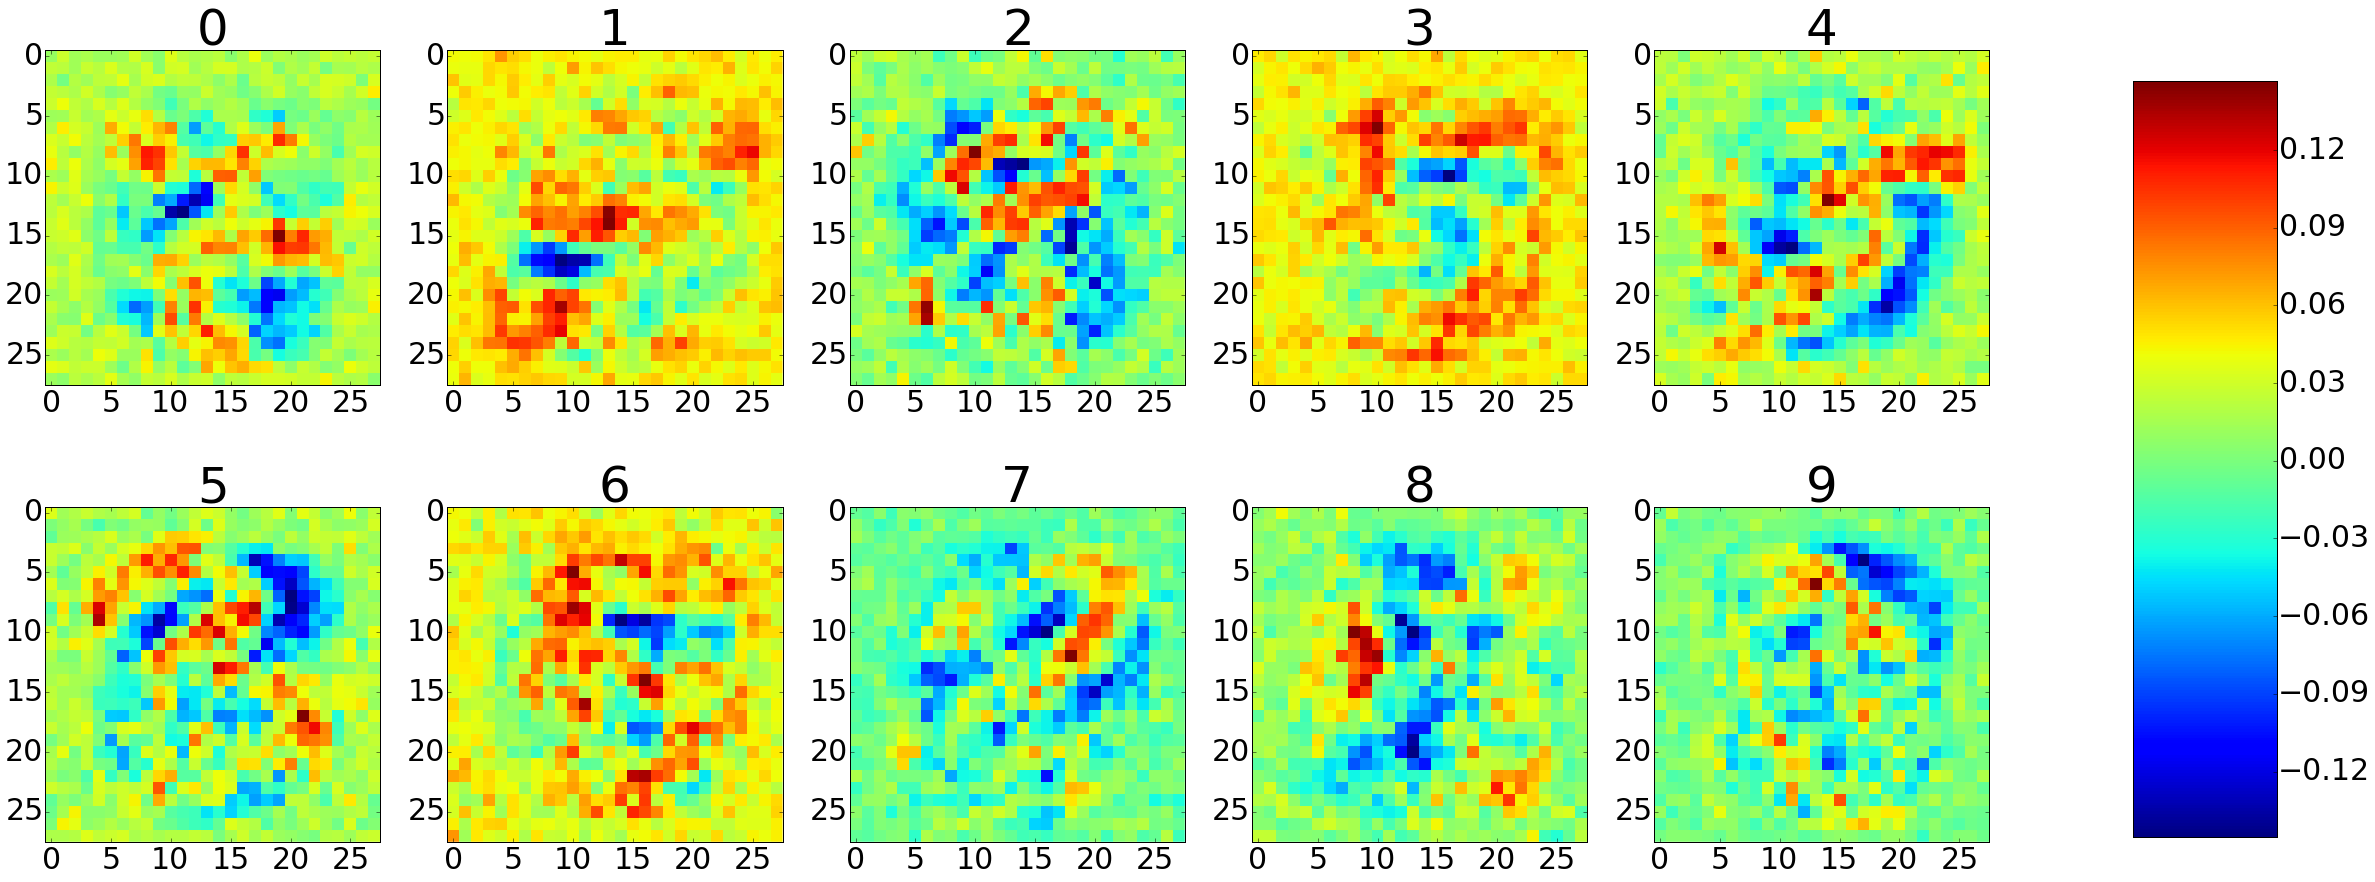

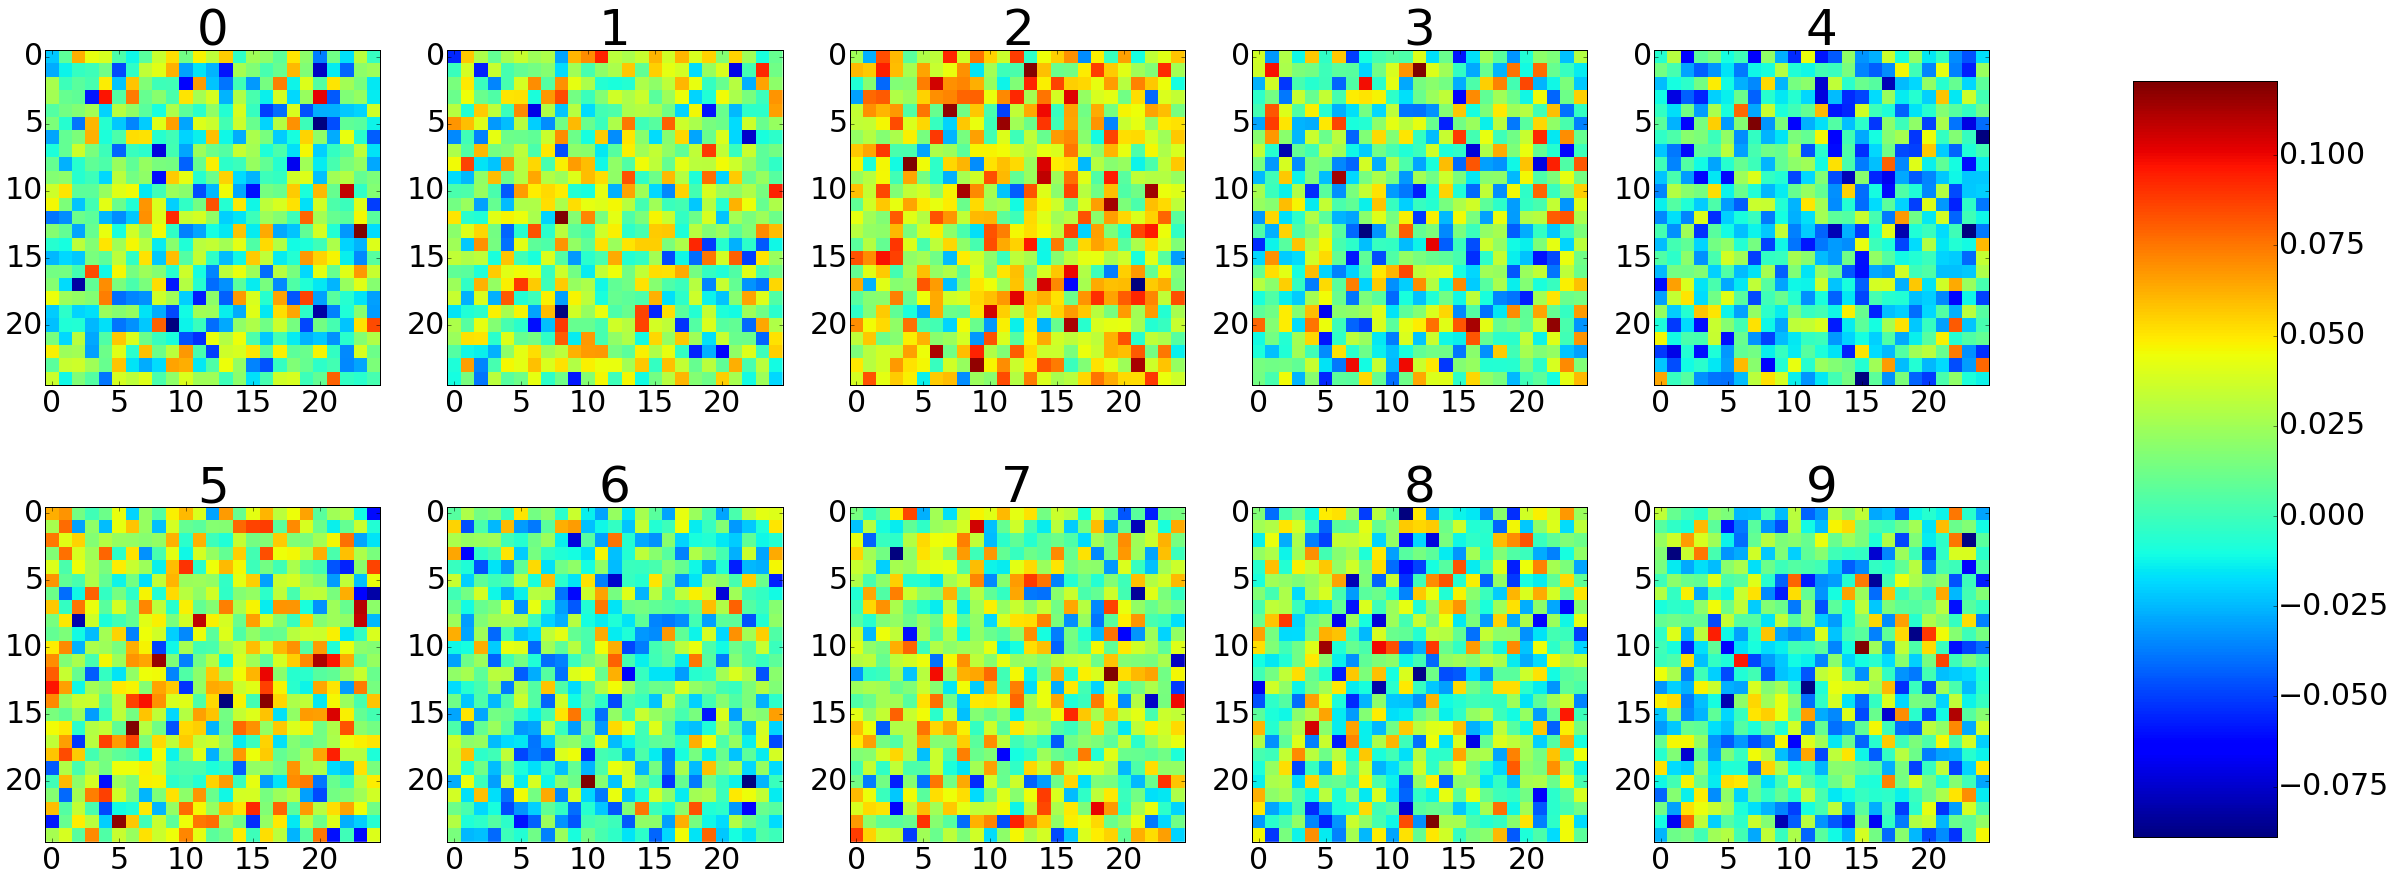

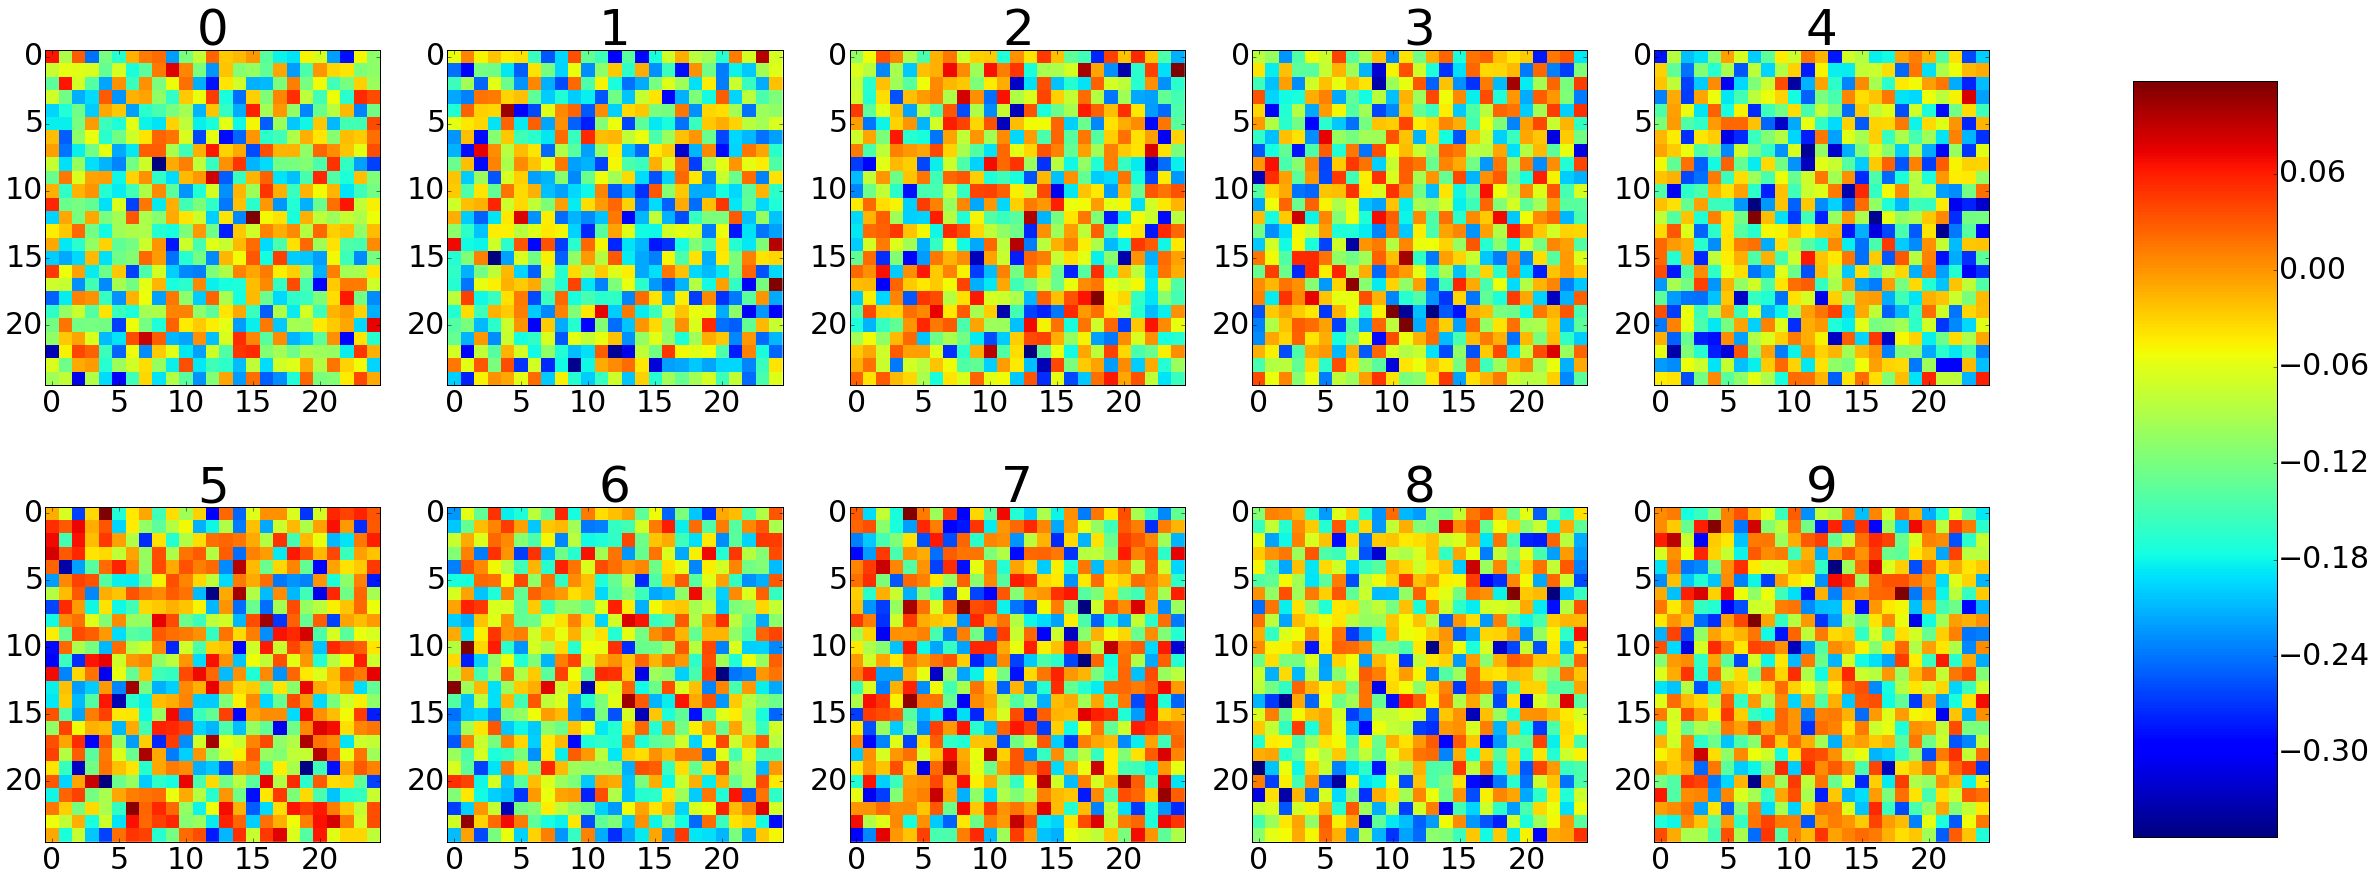

In [12]:
theano.printing.debugprint(py_x)
analyze_net(w_h, 28)
analyze_net(w_h2, 25)
analyze_net(w_o, 25)

In [ ]:
"""Convolutional Neural Network"""
from theano.tensor.nnet.conv import conv2d
from theano.tensor.signal.downsample import max_pool_2d

def model(X, w, w2, w3, w4, p_drop_conv, p_drop_hidden):
    l1a = rectify(conv2d(X, w, border_mode='full'))
    l1 = max_pool_2d(l1a, (2, 2))
    l1 = dropout(l1, p_drop_conv)

    l2a = rectify(conv2d(l1, w2))
    l2 = max_pool_2d(l2a, (2, 2))
    l2 = dropout(l2, p_drop_conv)

    l3a = rectify(conv2d(l2, w3))
    l3b = max_pool_2d(l3a, (2, 2))
    l3 = T.flatten(l3b, outdim=2)
    l3 = dropout(l3, p_drop_conv)

    l4 = rectify(T.dot(l3, w4))
    l4 = dropout(l4, p_drop_hidden)

    pyx = softmax(T.dot(l4, w_o))
    return l1, l2, l3, l4, pyx

trX, teX, trY, teY = mnist(onehot=True)

trX = trX.reshape(-1, 1, 28, 28)
teX = teX.reshape(-1, 1, 28, 28)

X = T.dtensor4()
Y = T.fmatrix()

w = init_weights((32, 1, 3, 3))
w2 = init_weights((64, 32, 3, 3))
w3 = init_weights((128, 64, 3, 3))
w4 = init_weights((128 * 3 * 3, 625))
w_o = init_weights((625, 10))

noise_l1, noise_l2, noise_l3, noise_l4, noise_py_x = model(X, w, w2, w3, w4, 0.2, 0.5)
l1, l2, l3, l4, py_x = model(X, w, w2, w3, w4, 0., 0.)
y_x = T.argmax(py_x, axis=1)


cost = T.mean(T.nnet.categorical_crossentropy(noise_py_x, Y))
params = [w, w2, w3, w4, w_o]
updates = RMSprop(cost, params, lr=0.001)

train = theano.function(inputs=[X, Y], outputs=cost, updates=updates, allow_input_downcast=True)
predict = theano.function(inputs=[X], outputs=y_x, allow_input_downcast=True)

for i in range(10):
    for start, end in zip(range(0, len(trX), 128), range(128, len(trX), 128)):
        cost = train(trX[start:end], trY[start:end])
    print np.mean(np.argmax(teY, axis=1) == predict(teX))

0.9476
0.9753
0.9839
0.9875
0.9851
0.9905
0.9908
0.991
0.9895